<a href="https://colab.research.google.com/github/jpandersen61/SQLLiteNotebooks/blob/main/North_Wind_Database_Changing__The_Database.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#North Wind Database - SQLite udgave - Ændring af database

Formålet med denne opgave er at ændre den oprindelige North Wind Database jf. en række forelåede ændringer, som fremgår af nedenstående ER-diagram.









##ER-Diagram (ændret udgave)

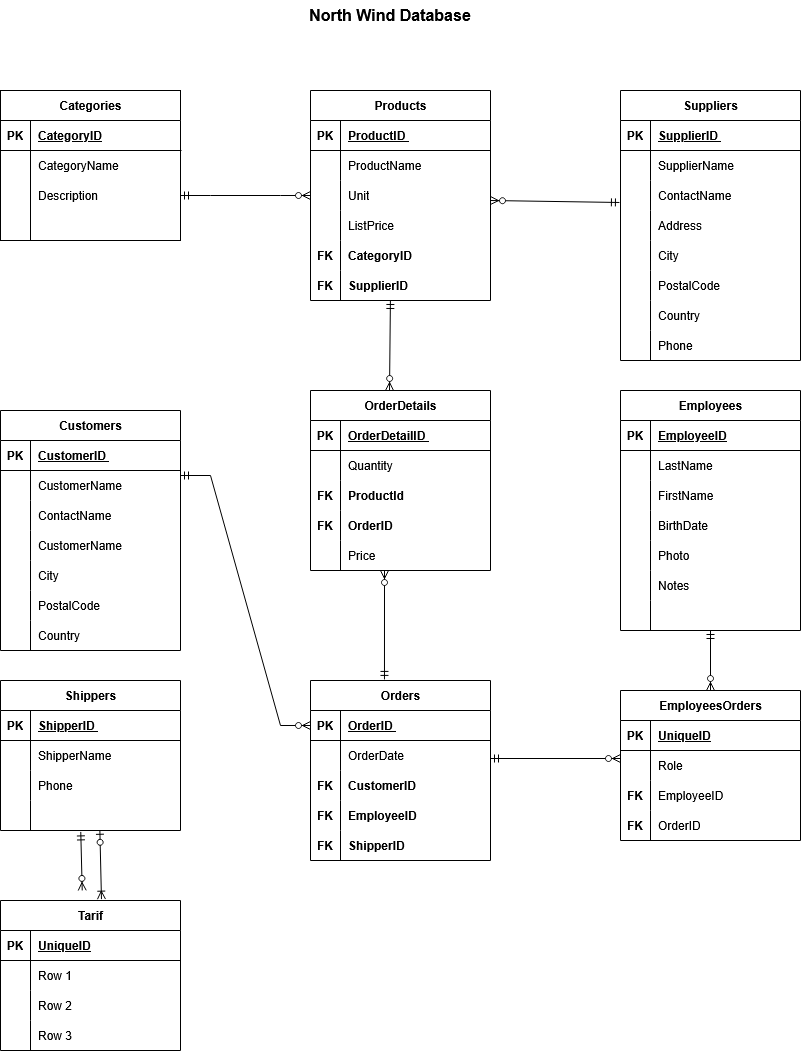

**Opgave**: Implementer følgende ændringer i databasen jf. ovenstående ER-diagram:
1. Opdatér Products og OrderDetails. Test at omsætningen herefter bliver beregnet korrekt.
2. Opdater Shippers – Orders relationen.
3. Tilføj Segment tabellen og implementer relationen til Products tabellen
4. Tilføj Competence tabellen og implementer relationen til Employees tabellen
5. Tilføj Tariff tabellen og implementer relationen til Shippers tabellen

**Løsning**: Implementeret i nedentående notebook

##Importing needed modules

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3

##Connecting to the database

I denne notebook benyttes [SQLite](https://sqlite.org/) databasen, der som det antydes er 'light', men som alligevel er OK til vores formål her, hvilket er at udvikle en database snarere end at drifte den.

In [ ]:
##Avoiding the 'database locked' error:

##Close the 'cursor' if present before proceeding
if 'SQLiteCursor' in globals():
    SQLiteCursor.close()

##Close the database connection if present before proceeding
if 'SQLiteConnetion' in globals():
    SQLiteConnetion.close()

In [ ]:
#Get connection to the sales system data - initially get an empty one
SQLiteConnetion = sqlite3.connect('demo.db')

In [ ]:
# create cursor object
SQLiteCursor = SQLiteConnetion.cursor()

##Slet eksisterende tabeller i databasen

Nedenstående SQL script bliver udført for at "rydde" databasen. Tabeller der er afhængige af andre tabeller bliver slettet først. Det er praktisk at slette alle tabeller først, fordi vi så undgår at skulle ændre i eksisterende tabeller og vi skal så kun koncentrere os om at oprette tabeller påny.

In [ ]:
SQLDropTableScript = """
DROP TABLE IF EXISTS Tariff;
DROP TABLE IF EXISTS Competence;
DROP TABLE IF EXISTS OrderDetails;
DROP TABLE IF EXISTS Orders;
DROP TABLE IF EXISTS Products;
DROP TABLE IF EXISTS Categories;
DROP TABLE IF EXISTS Customers;
DROP TABLE IF EXISTS Employees;
DROP TABLE IF EXISTS Shippers;
DROP TABLE IF EXISTS Segments;
DROP TABLE IF EXISTS Suppliers;
"""

In [ ]:
SQLiteCursor.executescript(SQLDropTableScript)

##Oprettelse af database-tabeller

Nedenstående SQL scripts opretter tabellerne i databasen. Brug dette som inspiration, når du selv skal oprette tabeller i databasen.

In [ ]:
SQLCreateDatabase = """
  CREATE TABLE Suppliers (
     SupplierID int NOT NULL PRIMARY KEY,
     SupplierName VARCHAR(50) NOT NULL,
     ContactName VARCHAR(50) NOT NULL,
     Address VARCHAR(50) NOT NULL,
     City VARCHAR(20) NOT NULL,
     PostalCode VARCHAR(10) NOT NULL,
     Country VARCHAR(15) NOT NULL,
     Phone VARCHAR(15) NOT NULL
     );

  CREATE TABLE Categories (
     CategoryID int NOT NULL PRIMARY KEY,
     CategoryName VARCHAR(25) NOT NULL,
     Description VARCHAR(255) NOT NULL
     );

  CREATE TABLE Customers (
    CustomerID int NOT NULL PRIMARY KEY,
    CustomerName VARCHAR(50) NOT NULL,
    ContactName VARCHAR(50) NOT NULL,
    Address VARCHAR(50) NOT NULL,
    City VARCHAR(20) NOT NULL,
    PostalCode VARCHAR(10) NOT NULL,
    Country VARCHAR(15) NOT NULL
    );

  CREATE TABLE Employees (
    EmployeeID int NOT NULL PRIMARY KEY,
    LastName VARCHAR(15) NOT NULL,
    FirstName VARCHAR(15) NOT NULL,
    BirthDate datetime NOT NULL,
    Photo VARCHAR(25) NOT NULL,
    Notes VARCHAR(1024) NOT NULL
    );

  CREATE TABLE Competence (
    CompetenceID int NOT NULL PRIMARY KEY,
    Type VARCHAR(15) NOT NULL,
    Duration int NOT NULL,
    EmployeeID int NOT NULL,
    FOREIGN KEY (EmployeeID) REFERENCES Employees(EmployeeID)
    );

  CREATE TABLE Products (
    ProductID int NOT NULL PRIMARY KEY,
    ProductName VARCHAR(50) NOT NULL,
    Unit VARCHAR(25) NOT NULL,
    ListPrice decimal(10,0) NOT NULL,
    SupplierID int NOT NULL,
    CategoryID int NOT NULL,
    SegmentID int DEFAULT NULL,
    FOREIGN KEY (SupplierID) REFERENCES Suppliers(SupplierID),
    FOREIGN KEY (CategoryID) REFERENCES Categories(CategoryID),
    FOREIGN KEY (SegmentID) REFERENCES Segments(SegmentID)
    );

  CREATE TABLE Segments (
    SegmentID int NOT NULL PRIMARY KEY,
    Name VARCHAR(25) NOT NULL,
    Description VARCHAR(255) NOT NULL
    );

  CREATE TABLE Shippers (
    ShipperID int NOT NULL PRIMARY KEY,
    ShipperName VARCHAR(25) NOT NULL,
    Phone VARCHAR(15) NOT NULL
    );

  CREATE TABLE Tariff (
    TariffID int NOT NULL PRIMARY KEY,
    Price int NOT NULL,
    ParcelDescription VARCHAR(30) NOT NULL,
    ShipperID int NOT NULL,
    FOREIGN KEY (ShipperID) REFERENCES Shippers(ShipperID)
    );

  CREATE TABLE Orders (
    OrderID int NOT NULL PRIMARY KEY,
    OrderDate datetime NOT NULL,
    CustomerID int NOT NULL,
    EmployeeID int NOT NULL,
    ShipperID int DEFAULT NULL,
    FOREIGN KEY (CustomerID) REFERENCES Customers(CustomerID),
    FOREIGN KEY (EmployeeID) REFERENCES Employees(EmployeeID),
    FOREIGN KEY (ShipperID) REFERENCES Shippers(ShipperID)
    );

  CREATE TABLE OrderDetails (
    OrderDetailID int NOT NULL PRIMARY KEY,
    Quantity int NOT NULL,
    Price decimal(10,0) NOT NULL,
    OrderID int NOT NULL,
    ProductID int NOT NULL,
    FOREIGN KEY (OrderID) REFERENCES Orders(OrderID),
    FOREIGN KEY (ProductID) REFERENCES Products(ProductID)
    );
"""

In [ ]:
SQLiteCursor.executescript (SQLCreateDatabase)

##Indsæt data i databasen

Nedenstående SQL-scripts indsætter data i databasen. Dette er meget nyttigt for at kunne indsætte eksempel-og testdata, hvor med vi kan demonstrere og teste vores forespørgsler til databasen.

In [ ]:
SQLInsertSuppliers = """
INSERT INTO Suppliers (SupplierID, SupplierName, ContactName, Address, City, PostalCode, Country, Phone) VALUES
(1, 'Exotic Liquid', 'Charlotte Cooper', '49 Gilbert St.', 'Londona', 'EC1 4SD', 'UK', '(171) 555-2222'),
(2, 'New Orleans Cajun Delights', 'Shelley Burke', 'P.O. Box 78934', 'New Orleans', '70117', 'USA', '(100) 555-4822'),
(3, 'Grandma Kelly\'\'s Homestead', 'Regina Murphy', '707 Oxford Rd.', 'Ann Arbor', '48104', 'USA', '(313) 555-5735'),
(4, 'Tokyo Traders', 'Yoshi Nagase', '9-8 Sekimai Musashino-shi', 'Tokyo', '100', 'Japan', '(03) 3555-5011'),
(5, 'Cooperativa de Quesos \'\'Las Cabras\'\'', 'Antonio del Valle Saavedra', 'Calle del Rosal 4', 'Oviedo', '33007', 'Spain', '(98) 598 76 54'),
(6, 'Mayumi\'\'s', 'Mayumi Ohno', '92 Setsuko Chuo-ku', 'Osaka', '545', 'Japan', '(06) 431-7877'),
(7, 'Pavlova, Ltd.', 'Ian Devling', '74 Rose St. Moonie Ponds', 'Melbourne', '3058', 'Australia', '(03) 444-2343'),
(8, 'Specialty Biscuits, Ltd.', 'Peter Wilson', '29 King\'\'s Way', 'Manchester', 'M14 GSD', 'UK', '(161) 555-4448'),
(9, 'PB Knäckebröd AB', 'Lars Peterson', 'Kaloadagatan 13', 'Göteborg', 'S-345 67', 'Sweden', '031-987 65 43'),
(10, 'Refrescos Americanas LTDA', 'Carlos Diaz', 'Av. das Americanas 12.890', 'São Paulo', '5442', 'Brazil', '(11) 555 4640'),
(11, 'Heli Süßwaren GmbH & Co. KG', 'Petra Winkler', 'Tiergartenstraße 5', 'Berlin', '10785', 'Germany', '(010) 9984510'),
(12, 'Plutzer Lebensmittelgroßmärkte AG', 'Martin Bein', 'Bogenallee 51', 'Frankfurt', '60439', 'Germany', '(069) 992755'),
(13, 'Nord-Ost-Fisch Handelsgesellschaft mbH', 'Sven Petersen', 'Frahmredder 112a', 'Cuxhaven', '27478', 'Germany', '(04721) 8713'),
(14, 'Formaggi Fortini s.r.l.', 'Elio Rossi', 'Viale Dante, 75', 'Ravenna', '48100', 'Italy', '(0544) 60323'),
(15, 'Norske Meierier', 'Beate Vileid', 'Hatlevegen 5', 'Sandvika', '1320', 'Norway', '(0)2-953010'),
(16, 'Bigfoot Breweries', 'Cheryl Saylor', '3400 - 8th Avenue Suite 210', 'Bend', '97101', 'USA', '(503) 555-9931'),
(17, 'Svensk Sjöföda AB', 'Michael Björn', 'Brovallavägen 231', 'Stockholm', 'S-123 45', 'Sweden', '08-123 45 67'),
(18, 'Aux joyeux ecclésiastiques', 'Guylène Nodier', '203, Rue des Francs-Bourgeois', 'Paris', '75004', 'France', '(1) 03.83.00.68'),
(19, 'New England Seafood Cannery', 'Robb Merchant', 'Order Processing Dept. 2100 Paul Revere Blvd.', 'Boston', '2134', 'USA', '(617) 555-3267'),
(20, 'Leka Trading', 'Chandra Leka', '471 Serangoon Loop, Suite #402', 'Singapore', '512', 'Singapore', '555-8787'),
(21, 'Lyngbysild', 'Niels Petersen', 'Lyngbysild Fiskebakken 10', 'Lyngby', '2800', 'Denmark', '43844108'),
(22, 'Zaanse Snoepfabriek', 'Dirk Luchte', 'Verkoop Rijnweg 22', 'Zaandam', '9999 ZZ', 'Netherlands', '(12345) 1212'),
(23, 'Karkki Oy', 'Anne Heikkonen', 'Valtakatu 12', 'Lappeenranta', '53120', 'Finland', '(953) 10956'),
(24, 'G\'\'day, Mate', 'Wendy Mackenzie', '170 Prince Edward Parade Hunter\'\'s Hill', 'Sydney', '2042', 'Australia', '(02) 555-5914'),
(25, 'Ma Maison', 'Jean-Guy Lauzon', '2960 Rue St. Laurent', 'Montréal', 'H1J 1C3', 'Canada', '(514) 555-9022'),
(26, 'Pasta Buttini s.r.l.', 'Giovanni Giudici', 'Via dei Gelsomini, 153', 'Salerno', '84100', 'Italy', '(089) 6547665'),
(27, 'Escargots Nouveaux', 'Marie Delamare', '22, rue H. Voiron', 'Montceau', '71300', 'France', '85.57.00.07'),
(28, 'Gai pâturage', 'Eliane Noz', 'Bat. B 3, rue des Alpes', 'Annecy', '74000', 'France', '38.76.98.06'),
(29, 'Forêts d\'\'érables', 'Chantal Goulet', '148 rue Chasseur', 'Ste-Hyacinthe', 'J2S 7S8', 'Canada', '(514) 555-2955');
"""

In [ ]:
SQLiteCursor.execute(SQLInsertSuppliers)

In [ ]:
SQLInsertCategories = """
INSERT INTO Categories (CategoryID, CategoryName, Description) VALUES
(1, 'Beverages', 'Soft drinks, coffees, teas, beers, and ales'),
(2, 'Condiments', 'Sweet and savory sauces, relishes, spreads, and seasonings'),
(3, 'Confections', 'Desserts, candies, and sweet breads'),
(4, 'Dairy Products', 'Cheeses'),
(5, 'Grains/Cereals', 'Breads, crackers, pasta, and cereal'),
(6, 'Meat/Poultry', 'Prepared meats'),
(7, 'Produce', 'Dried fruit and bean curd'),
(8, 'Seafood', 'Seaweed and fish');
"""

In [ ]:
SQLiteCursor.execute(SQLInsertCategories)

In [ ]:
SQLInsertCustomers = """
INSERT INTO Customers (CustomerID, CustomerName, ContactName, Address, City, PostalCode, Country) VALUES
(1, 'Alfreds Futterkiste', 'Maria Anders', 'Obere Str. 57', 'Berlin', '12209', 'Germany'),
(2, 'Ana Trujillo Emparedados y helados', 'Ana Trujillo', 'Avda. de la Constitución 2222', 'México D.F.', '5021', 'Mexico'),
(3, 'Antonio Moreno Taquería', 'Antonio Moreno', 'Mataderos 2312', 'México D.F.', '5023', 'Mexico'),
(4, 'Around the Horn', 'Thomas Hardy', '120 Hanover Sq.', 'London', 'WA1 1DP', 'UK'),
(5, 'Berglunds snabbköp', 'Christina Berglund', 'Berguvsvägen 8', 'Luleå', 'S-958 22', 'Sweden'),
(6, 'Blauer See Delikatessen', 'Hanna Moos', 'Forsterstr. 57', 'Mannheim', '68306', 'Germany'),
(7, 'Blondel père et fils', 'Frédérique Citeaux', '24, place Kléber', 'Strasbourg', '67000', 'France'),
(8, 'Bólido Comidas preparadas', 'Martín Sommer', 'C/ Araquil, 67', 'Madrid', '28023', 'Spain'),
(9, 'Bon app\'\'', 'Laurence Lebihans', '12, rue des Bouchers', 'Marseille', '13008', 'France'),
(10, 'Bottom-Dollar Marketse', 'Elizabeth Lincoln', '23 Tsawassen Blvd.', 'Tsawassen', 'T2F 8M4', 'Canada'),
(11, 'B\'\'s Beverages', 'Victoria Ashworth', 'Fauntleroy Circus', 'London', 'EC2 5NT', 'UK'),
(12, 'Cactus Comidas para llevar', 'Patricio Simpson', 'Cerrito 333', 'Buenos Aires', '1010', 'Argentina'),
(13, 'Centro comercial Moctezuma', 'Francisco Chang', 'Sierras de Granada 9993', 'México D.F.', '5022', 'Mexico'),
(14, 'Chop-suey Chinese', 'Yang Wang', 'Hauptstr. 29', 'Bern', '3012', 'Switzerland'),
(15, 'Comércio Mineiro', 'Pedro Afonso', 'Av. dos Lusíadas, 23', 'São Paulo', '05432-043', 'Brazil'),
(16, 'Consolidated Holdings', 'Elizabeth Brown', 'Berkeley Gardens 12 Brewery', 'London', 'WX1 6LT', 'UK'),
(17, 'Drachenblut Delikatessend', 'Sven Ottlieb', 'Walserweg 21', 'Aachen', '52066', 'Germany'),
(18, 'Du monde entier', 'Janine Labrune', '67, rue des Cinquante Otages', 'Nantes', '44000', 'France'),
(19, 'Eastern Connection', 'Ann Devon', '35 King George', 'London', 'WX3 6FW', 'UK'),
(20, 'Ernst Handel', 'Roland Mendel', 'Kirchgasse 6', 'Graz', '8010', 'Austria'),
(21, 'Familia Arquibaldo', 'Aria Cruz', 'Rua Orós, 92', 'São Paulo', '05442-030', 'Brazil'),
(22, 'FISSA Fabrica Inter. Salchichas S.A.', 'Diego Roel', 'C/ Moralzarzal, 86', 'Madrid', '28034', 'Spain'),
(23, 'Folies gourmandes', 'Martine Rancé', '184, chaussée de Tournai', 'Lille', '59000', 'France'),
(24, 'Folk och fä HB', 'Maria Larsson', 'Åkergatan 24', 'Bräcke', 'S-844 67', 'Sweden'),
(25, 'Frankenversand', 'Peter Franken', 'Berliner Platz 43', 'München', '80805', 'Germany'),
(26, 'France restauration', 'Carine Schmitt', '54, rue Royale', 'Nantes', '44000', 'France'),
(27, 'Franchi S.p.A.', 'Paolo Accorti', 'Via Monte Bianco 34', 'Torino', '10100', 'Italy'),
(28, 'Furia Bacalhau e Frutos do Mar', 'Lino Rodriguez', 'Jardim das rosas n. 32', 'Lisboa', '1675', 'Portugal'),
(29, 'Galería del gastrónomo', 'Eduardo Saavedra', 'Rambla de Cataluña, 23', 'Barcelona', '8022', 'Spain'),
(30, 'Godos Cocina Típica', 'José Pedro Freyre', 'C/ Romero, 33', 'Sevilla', '41101', 'Spain'),
(31, 'Gourmet Lanchonetes', 'André Fonseca', 'Av. Brasil, 442', 'Campinas', '04876-786', 'Brazil'),
(32, 'Great Lakes Food Market', 'Howard Snyder', '2732 Baker Blvd.', 'Eugene', '97403', 'USA'),
(33, 'GROSELLA-Restaurante', 'Manuel Pereira', '5ª Ave. Los Palos Grandes', 'Caracas', '1081', 'Venezuela'),
(34, 'Hanari Carnes', 'Mario Pontes', 'Rua do Paço, 67', 'Rio de Janeiro', '05454-876', 'Brazil'),
(35, 'HILARIÓN-Abastos', 'Carlos Hernández', 'Carrera 22 con Ave. Carlos Soublette #8-35', 'San Cristóbal', '5022', 'Venezuela'),
(36, 'Hungry Coyote Import Store', 'Yoshi Latimer', 'City Center Plaza 516 Main St.', 'Elgin', '97827', 'USA'),
(37, 'Hungry Owl All-Night Grocers', 'Patricia McKenna', '8 Johnstown Road', 'Cork', '', 'Ireland'),
(38, 'Island Trading', 'Helen Bennett', 'Garden House Crowther Way', 'Cowes', 'PO31 7PJ', 'UK'),
(39, 'Königlich Essen', 'Philip Cramer', 'Maubelstr. 90', 'Brandenburg', '14776', 'Germany'),
(40, 'La corne d\'\'abondance', 'Daniel Tonini', '67, avenue de l\'\'Europe', 'Versailles', '78000', 'France'),
(41, 'La maison d\'\'Asie', 'Annette Roulet', '1 rue Alsace-Lorraine', 'Toulouse', '31000', 'France'),
(42, 'Laughing Bacchus Wine Cellars', 'Yoshi Tannamuri', '1900 Oak St.', 'Vancouver', 'V3F 2K1', 'Canada'),
(43, 'Lazy K Kountry Store', 'John Steel', '12 Orchestra Terrace', 'Walla Walla', '99362', 'USA'),
(44, 'Lehmanns Marktstand', 'Renate Messner', 'Magazinweg 7', 'Frankfurt a.M.', '60528', 'Germany'),
(45, 'Let\'\'s Stop N Shop', 'Jaime Yorres', '87 Polk St. Suite 5', 'San Francisco', '94117', 'USA'),
(46, 'LILA-Supermercado', 'Carlos González', 'Carrera 52 con Ave. Bolívar #65-98 Llano Largo', 'Barquisimeto', '3508', 'Venezuela'),
(47, 'LINO-Delicateses', 'Felipe Izquierdo', 'Ave. 5 de Mayo Porlamar', 'I. de Margarita', '4980', 'Venezuela'),
(48, 'Lonesome Pine Restaurant', 'Fran Wilson', '89 Chiaroscuro Rd.', 'Portland', '97219', 'USA'),
(49, 'Magazzini Alimentari Riuniti', 'Giovanni Rovelli', 'Via Ludovico il Moro 22', 'Bergamo', '24100', 'Italy'),
(50, 'Maison Dewey', 'Catherine Dewey', 'Rue Joseph-Bens 532', 'Bruxelles', 'B-1180', 'Belgium'),
(51, 'Mère Paillarde', 'Jean Fresnière', '43 rue St. Laurent', 'Montréal', 'H1J 1C3', 'Canada'),
(52, 'Morgenstern Gesundkost', 'Alexander Feuer', 'Heerstr. 22', 'Leipzig', '4179', 'Germany'),
(53, 'North/South', 'Simon Crowther', 'South House 300 Queensbridge', 'London', 'SW7 1RZ', 'UK'),
(54, 'Océano Atlántico Ltda.', 'Yvonne Moncada', 'Ing. Gustavo Moncada 8585 Piso 20-A', 'Buenos Aires', '1010', 'Argentina'),
(55, 'Old World Delicatessen', 'Rene Phillips', '2743 Bering St.', 'Anchorage', '99508', 'USA'),
(56, 'Ottilies Käseladen', 'Henriette Pfalzheim', 'Mehrheimerstr. 369', 'Köln', '50739', 'Germany'),
(57, 'Paris spécialités', 'Marie Bertrand', '265, boulevard Charonne', 'Paris', '75012', 'France'),
(58, 'Pericles Comidas clásicas', 'Guillermo Fernández', 'Calle Dr. Jorge Cash 321', 'México D.F.', '5033', 'Mexico'),
(59, 'Piccolo und mehr', 'Georg Pipps', 'Geislweg 14', 'Salzburg', '5020', 'Austria'),
(60, 'Princesa Isabel Vinhoss', 'Isabel de Castro', 'Estrada da saúde n. 58', 'Lisboa', '1756', 'Portugal'),
(61, 'Que Delícia', 'Bernardo Batista', 'Rua da Panificadora, 12', 'Rio de Janeiro', '02389-673', 'Brazil'),
(62, 'Queen Cozinha', 'Lúcia Carvalho', 'Alameda dos Canàrios, 891', 'São Paulo', '05487-020', 'Brazil'),
(63, 'QUICK-Stop', 'Horst Kloss', 'Taucherstraße 10', 'Cunewalde', '1307', 'Germany'),
(64, 'Rancho grande', 'Sergio Gutiérrez', 'Av. del Libertador 900', 'Buenos Aires', '1010', 'Argentina'),
(65, 'Rattlesnake Canyon Grocery', 'Paula Wilson', '2817 Milton Dr.', 'Albuquerque', '87110', 'USA'),
(66, 'Reggiani Caseifici', 'Maurizio Moroni', 'Strada Provinciale 124', 'Reggio Emilia', '42100', 'Italy'),
(67, 'Ricardo Adocicados', 'Janete Limeira', 'Av. Copacabana, 267', 'Rio de Janeiro', '02389-890', 'Brazil'),
(68, 'Richter Supermarkt', 'Michael Holz', 'Grenzacherweg 237', 'Genève', '1203', 'Switzerland'),
(69, 'Romero y tomillo', 'Alejandra Camino', 'Gran Vía, 1', 'Madrid', '28001', 'Spain'),
(70, 'Santé Gourmet', 'Jonas Bergulfsen', 'Erling Skakkes gate 78', 'Stavern', '4110', 'Norway'),
(71, 'Save-a-lot Markets', 'Jose Pavarotti', '187 Suffolk Ln.', 'Boise', '83720', 'USA'),
(72, 'Seven Seas Imports', 'Hari Kumar', '90 Wadhurst Rd.', 'London', 'OX15 4NB', 'UK'),
(73, 'Simons bistro', 'Jytte Petersen', 'Vinbæltet 34', 'København', '1734', 'Denmark'),
(74, 'Spécialités du monde', 'Dominique Perrier', '25, rue Lauriston', 'Paris', '75016', 'France'),
(75, 'Split Rail Beer & Ale', 'Art Braunschweiger', 'P.O. Box 555', 'Lander', '82520', 'USA'),
(76, 'Suprêmes délices', 'Pascale Cartrain', 'Boulevard Tirou, 255', 'Charleroi', 'B-6000', 'Belgium'),
(77, 'The Big Cheese', 'Liz Nixon', '89 Jefferson Way Suite 2', 'Portland', '97201', 'USA'),
(78, 'The Cracker Box', 'Liu Wong', '55 Grizzly Peak Rd.', 'Butte', '59801', 'USA'),
(79, 'Toms Spezialitäten', 'Karin Josephs', 'Luisenstr. 48', 'Münster', '44087', 'Germany'),
(80, 'Tortuga Restaurante', 'Miguel Angel Paolino', 'Avda. Azteca 123', 'México D.F.', '5033', 'Mexico'),
(81, 'Tradição Hipermercados', 'Anabela Domingues', 'Av. Inês de Castro, 414', 'São Paulo', '05634-030', 'Brazil'),
(82, 'Trail\'\'s Head Gourmet Provisioners', 'Helvetius Nagy', '722 DaVinci Blvd.', 'Kirkland', '98034', 'USA'),
(83, 'Vaffeljernet', 'Palle Ibsen', 'Smagsløget 45', 'Århus', '8200', 'Denmark'),
(84, 'Victuailles en stock', 'Mary Saveley', '2, rue du Commerce', 'Lyon', '69004', 'France'),
(85, 'Vins et alcools Chevalier', 'Paul Henriot', '59 rue de l\'\'Abbaye', 'Reims', '51100', 'France'),
(86, 'Die Wandernde Kuh', 'Rita Müller', 'Adenauerallee 900', 'Stuttgart', '70563', 'Germany'),
(87, 'Wartian Herkku', 'Pirkko Koskitalo', 'Torikatu 38', 'Oulu', '90110', 'Finland'),
(88, 'Wellington Importadora', 'Paula Parente', 'Rua do Mercado, 12', 'Resende', '08737-363', 'Brazil'),
(89, 'White Clover Markets', 'Karl Jablonski', '305 - 14th Ave. S. Suite 3B', 'Seattle', '98128', 'USA'),
(90, 'Wilman Kala', 'Matti Karttunen', 'Keskuskatu 45', 'Helsinki', '21240', 'Finland'),
(91, 'Wolski', 'Zbyszek', 'ul. Filtrowa 68', 'Walla', '01-012', 'Poland');
"""

In [ ]:
SQLiteCursor.execute(SQLInsertCustomers)

In [ ]:
SQLInsertEmployees = """
INSERT INTO Employees (EmployeeID, LastName, FirstName, BirthDate, Photo, Notes) VALUES
(1, 'Davolio', 'Nancy', '1968-12-08 00:00:00', 'EmpID1.pic', 'Education includes a BA in psychology from Colorado State University. She also completed (The Art of the Cold Call). Nancy is a member of Toastmasters International.'),
(2, 'Fuller', 'Andrew', '1952-02-19 00:00:00', 'EmpID2.pic', 'Andrew received his BTS commercial and a Ph.D. in international marketing from the University of Dallas. He is fluent in French and Italian and reads German. He joined the company as a sales representative, was promoted to sales manager and was then named vice president of sales. Andrew is a member of the Sales Management Roundtable, the Seattle Chamber of Commerce, and the Pacific Rim Importers Association.'),
(3, 'Leverling', 'Janet', '1963-08-30 00:00:00', 'EmpID3.pic', 'Janet has a BS degree in chemistry from Boston College). She has also completed a certificate program in food retailing management. Janet was hired as a sales associate and was promoted to sales representative.'),
(4, 'Peacock', 'Margaret', '1958-09-19 00:00:00', 'EmpID4.pic', 'Margaret holds a BA in English literature from Concordia College and an MA from the American Institute of Culinary Arts. She was temporarily assigned to the London office before returning to her permanent post in Seattle.'),
(5, 'Buchanan', 'Steven', '1955-03-04 00:00:00', 'EmpID5.pic', 'Steven Buchanan graduated from St. Andrews University, Scotland, with a BSC degree. Upon joining the company as a sales representative, he spent 6 months in an orientation program at the Seattle office and then returned to his permanent post in London, where he was promoted to sales manager. Mr. Buchanan has completed the courses Successful Telemarketing and International Sales Management. He is fluent in French.'),
(6, 'Suyama', 'Michael', '1963-07-02 00:00:00', 'EmpID6.pic', 'Michael is a graduate of Sussex University (MA, economics) and the University of California at Los Angeles (MBA, marketing). He has also taken the courses Multi-Cultural Selling and Time Management for the Sales Professional. He is fluent in Japanese and can read and write French, Portuguese, and Spanish.'),
(7, 'King', 'Robert', '1960-05-29 00:00:00', 'EmpID7.pic', 'Robert King served in the Peace Corps and traveled extensively before completing his degree in English at the University of Michigan and then joining the company. After completing a course entitled Selling in Europe, he was transferred to the London office.'),
(8, 'Callahan', 'Laura', '1958-01-09 00:00:00', 'EmpID8.pic', 'Laura received a BA in psychology from the University of Washington. She has also completed a course in business French. She reads and writes French.'),
(9, 'Dodsworth', 'Anne', '1969-07-02 00:00:00', 'EmpID9.pic', 'Anne has a BA degree in English from St. Lawrence College. She is fluent in French and German.'),
(10, 'West', 'Adam', '1928-09-19 00:00:00', 'EmpID10.pic', 'An old chum.');
"""

In [ ]:
SQLiteCursor.execute(SQLInsertEmployees)

In [ ]:
#In fact created with AI
SQLInsertCompetence = """
INSERT INTO Competence (CompetenceID, Type, Duration, EmployeeID) VALUES
(1, 'Sales Training', 40, 1),
(2, 'Product Knowledge', 20, 1),
(3, 'Leadership', 60, 2),
(4, 'Foreign Language', 30, 2),
(5, 'Customer Service', 25, 3),
(6, 'Marketing', 35, 4),
(7, 'Financial Analysis', 50, 5),
(8, 'IT Skills', 45, 6),
(9, 'Negotiation', 55, 7),
(10, 'Public Speaking', 20, 8),
(11, 'Project Management', 40, 9),
(12, 'Historical Knowledge', 10, 10)
;
"""

In [ ]:
SQLiteCursor.execute(SQLInsertCompetence)

In [ ]:
SQLInsertProducts = """
INSERT INTO Products (ProductID, ProductName, SupplierID, CategoryID, Unit, ListPrice) VALUES
(1, 'Chais', 1, 1, '10 boxes x 20 bags', 18),
(2, 'Chang', 1, 1, '24 - 12 oz bottles', 19),
(3, 'Aniseed Syrup', 1, 2, '12 - 550 ml bottles', 10),
(4, 'Chef Anton\'\'s Cajun Seasoning', 2, 2, '48 - 6 oz jars', 22),
(5, 'Chef Anton\'\'s Gumbo Mix', 2, 2, '36 boxes', 21),
(6, 'Grandmas Boysenberry Spread', 3, 2, '12 - 8 oz jars', 25),
(7, 'Uncle Bobs Organic Dried Pears', 3, 7, '12 - 1 lb pkgs.', 30),
(8, 'Northwoods Cranberry Sauce', 3, 2, '12 - 12 oz jars', 40),
(9, 'Mishi Kobe Niku', 4, 6, '18 - 500 g pkgs.', 97),
(10, 'Ikura', 4, 8, '12 - 200 ml jars', 31),
(11, 'Queso Cabrales', 5, 4, '1 kg pkg.', 21),
(12, 'Queso Manchego La Pastora', 5, 4, '10 - 500 g pkgs.', 38),
(13, 'Konbu', 6, 8, '2 kg box', 6),
(14, 'Tofu', 6, 7, '40 - 100 g pkgs.', 23),
(15, 'Genen Shouyu', 6, 2, '24 - 250 ml bottles', 16),
(16, 'Pavlova', 7, 3, '32 - 500 g boxes', 17),
(17, 'Alice Mutton', 7, 6, '20 - 1 kg tins', 39),
(18, 'Carnarvon Tigers', 7, 8, '16 kg pkg.', 63),
(19, 'Teatime Chocolate Biscuits', 8, 3, '10 boxes x 12 pieces', 9),
(20, 'Sir Rodneys Marmalade', 8, 3, '30 gift boxes', 81),
(21, 'Sir Rodneys Scones', 8, 3, '24 pkgs. x 4 pieces', 10),
(22, 'Gustafs Knäckebröd', 9, 5, '24 - 500 g pkgs.', 21),
(23, 'Tunnbröd', 9, 5, '12 - 250 g pkgs.', 9),
(24, 'Guaraná Fantástica', 10, 1, '12 - 355 ml cans', 5),
(25, 'NuNuCa Nuß-Nougat-Creme', 11, 3, '20 - 450 g glasses', 14),
(26, 'Gumbär Gummibärchen', 11, 3, '100 - 250 g bags', 31),
(27, 'Schoggi Schokolade', 11, 3, '100 - 100 g pieces', 44),
(28, 'Rössle Sauerkraut', 12, 7, '25 - 825 g cans', 46),
(29, 'Thüringer Rostbratwurst', 12, 6, '50 bags x 30 sausgs.', 124),
(30, 'Nord-Ost Matjeshering', 13, 8, '10 - 200 g glasses', 26),
(31, 'Gorgonzola Telino', 14, 4, '12 - 100 g pkgs', 13),
(32, 'Mascarpone Fabioli', 14, 4, '24 - 200 g pkgs.', 32),
(33, 'Geitost', 15, 4, '500 g', 3),
(34, 'Sasquatch Ale', 16, 1, '24 - 12 oz bottles', 14),
(35, 'Steeleye Stout', 16, 1, '24 - 12 oz bottles', 18),
(36, 'Inlagd Sill', 17, 8, '24 - 250 g jars', 19),
(37, 'Gravad lax', 17, 8, '12 - 500 g pkgs.', 26),
(38, 'Côte de Blaye', 18, 1, '12 - 75 cl bottles', 264),
(39, 'Chartreuse verte', 18, 1, '750 cc per bottle', 18),
(40, 'Boston Crab Meat', 19, 8, '24 - 4 oz tins', 18),
(41, 'Jacks New England Clam Chowder', 19, 8, '12 - 12 oz cans', 10),
(42, 'Singaporean Hokkien Fried Mee', 20, 5, '32 - 1 kg pkgs.', 14),
(43, 'Ipoh Coffee', 20, 1, '16 - 500 g tins', 46),
(44, 'Gula Malacca', 20, 2, '20 - 2 kg bags', 19),
(45, 'Røgede sild', 21, 8, '1k pkg.', 10),
(46, 'Spegesild', 21, 8, '4 - 450 g glasses', 12),
(47, 'Zaanse koeken', 22, 3, '10 - 4 oz boxes', 10),
(48, 'Chocolade', 22, 3, '10 pkgs.', 13),
(49, 'Maxilaku', 23, 3, '24 - 50 g pkgs.', 20),
(50, 'Valkoinen suklaa', 23, 3, '12 - 100 g bars', 16),
(51, 'Manjimup Dried Apples', 24, 7, '50 - 300 g pkgs.', 53),
(52, 'Filo Mix', 24, 5, '16 - 2 kg boxes', 7),
(53, 'Perth Pasties', 24, 6, '48 pieces', 33),
(54, 'Tourtière', 25, 6, '16 pies', 7),
(55, 'Pâté chinois', 25, 6, '24 boxes x 2 pies', 24),
(56, 'Gnocchi di nonna Alice', 26, 5, '24 - 250 g pkgs.', 38),
(57, 'Ravioli Angelo', 26, 5, '24 - 250 g pkgs.', 20),
(58, 'Escargots de Bourgogne', 27, 8, '24 pieces', 13),
(59, 'Raclette Courdavault', 28, 4, '5 kg pkg.', 55),
(60, 'Camembert Pierrot', 28, 4, '15 - 300 g rounds', 34),
(61, 'Sirop dérable', 29, 2, '24 - 500 ml bottles', 29),
(62, 'Tarte au sucre', 29, 3, '48 pies', 49),
(63, 'Vegie-spread', 7, 2, '15 - 625 g jars', 44),
(64, 'Wimmers gute Semmelknödel', 12, 5, '20 bags x 4 pieces', 33),
(65, 'Louisiana Fiery Hot Pepper Sauce', 2, 2, '32 - 8 oz bottles', 21),
(66, 'Louisiana Hot Spiced Okra', 2, 2, '24 - 8 oz jars', 17),
(67, 'Laughing Lumberjack Lager', 16, 1, '24 - 12 oz bottles', 14),
(68, 'Scottish Longbreads', 8, 3, '10 boxes x 8 pieces', 13),
(69, 'Gudbrandsdalsost', 15, 4, '10 kg pkg.', 36),
(70, 'Outback Lager', 7, 1, '24 - 355 ml bottles', 15),
(71, 'Fløtemysost', 15, 4, '10 - 500 g pkgs.', 22),
(72, 'Mozzarella di Giovanni', 14, 4, '24 - 200 g pkgs.', 35),
(73, 'Röd Kaviar', 17, 8, '24 - 150 g jars', 15),
(74, 'Longlife Tofu', 4, 7, '5 kg pkg.', 10),
(75, 'Rhönbräu Klosterbier', 12, 1, '24 - 0.5 l bottles', 8),
(76, 'Lakkalikööri', 23, 1, '500 ml', 18),
(77, 'Original Frankfurter grüne Soße', 12, 2, '12 boxes', 13);
"""

In [ ]:
SQLiteCursor.execute(SQLInsertProducts)

In [ ]:
SQLInsertSegments = """
INSERT INTO Segments (SegmentID, Name, Description) VALUES
(1, 'YoungAndBeautiful', 'Goes for the latest fashion'),
(2, 'OldAndRich', 'Goes for ultimate quality - dont care about price '),
(3, 'Family', 'Goes for high quantity - low price');
"""

In [ ]:
SQLiteCursor.execute(SQLInsertSegments)

In [ ]:
SQLInsertShippers = """
INSERT INTO Shippers (ShipperID, ShipperName, Phone) VALUES
(1, 'Speedy Express', '(503) 555-9831'),
(2, 'United Package', '(503) 555-3199'),
(3, 'Federal Shipping', '(503) 555-9931');
"""


In [ ]:
SQLiteCursor.execute(SQLInsertShippers)

In [ ]:
#In fact alterred with AI
SQLInsertTariff = """
INSERT INTO Tariff (TariffID, Price, ParcelDescription, ShipperID) VALUES
(1, 5, 'Small parcel (up to 1kg)', 1),
(2, 10, 'Medium parcel (1kg-5kg)', 1),
(3, 20, 'Large parcel (over 5kg)', 1),
(4, 6, 'Small parcel (up to 1kg)', 2),
(5, 12, 'Medium parcel (1kg-5kg)', 2),
(6, 25, 'Large parcel (over 5kg)', 2),
(7, 7, 'Small parcel (up to 1kg)', 3),
(8, 14, 'Medium parcel (1kg-5kg)', 3),
(9, 30, 'Large parcel (over 5kg)', 3)
;
"""

In [ ]:
SQLiteCursor.execute(SQLInsertTariff)

In [ ]:
#Test by allowing at least ShipperID to be NULL
SQLInsertOrders = """
INSERT INTO Orders (OrderID, CustomerID, EmployeeID, OrderDate, ShipperID) VALUES
(10248, 90, 5, '1996-07-04 00:00:00', NULL),
(10249, 81, 6, '1996-07-05 00:00:00', 1),
(10250, 34, 4, '1996-07-08 00:00:00', 2),
(10251, 84, 3, '1996-07-08 00:00:00', 1),
(10252, 76, 4, '1996-07-09 00:00:00', 2),
(10253, 34, 3, '1996-07-10 00:00:00', 2),
(10254, 14, 5, '1996-07-11 00:00:00', 2),
(10255, 68, 9, '1996-07-12 00:00:00', 3),
(10256, 88, 3, '1996-07-15 00:00:00', 2),
(10257, 35, 4, '1996-07-16 00:00:00', 3),
(10258, 20, 1, '1996-07-17 00:00:00', 1),
(10259, 13, 4, '1996-07-18 00:00:00', 3),
(10260, 55, 4, '1996-07-19 00:00:00', 1),
(10261, 61, 4, '1996-07-19 00:00:00', 2),
(10262, 65, 8, '1996-07-22 00:00:00', 3),
(10263, 20, 9, '1996-07-23 00:00:00', 3),
(10264, 24, 6, '1996-07-24 00:00:00', 3),
(10265, 7, 2, '1996-07-25 00:00:00', 1),
(10266, 87, 3, '1996-07-26 00:00:00', 3),
(10267, 25, 4, '1996-07-29 00:00:00', 1),
(10268, 33, 8, '1996-07-30 00:00:00', 3),
(10269, 89, 5, '1996-07-31 00:00:00', 1),
(10270, 87, 1, '1996-08-01 00:00:00', 1),
(10271, 75, 6, '1996-08-01 00:00:00', 2),
(10272, 65, 6, '1996-08-02 00:00:00', 2),
(10273, 63, 3, '1996-08-05 00:00:00', 3),
(10274, 85, 6, '1996-08-06 00:00:00', 1),
(10275, 49, 1, '1996-08-07 00:00:00', 1),
(10276, 80, 8, '1996-08-08 00:00:00', 3),
(10277, 52, 2, '1996-08-09 00:00:00', 3),
(10278, 5, 8, '1996-08-12 00:00:00', 2),
(10279, 44, 8, '1996-08-13 00:00:00', 2),
(10280, 5, 2, '1996-08-14 00:00:00', 1),
(10281, 69, 4, '1996-08-14 00:00:00', 1),
(10282, 69, 4, '1996-08-15 00:00:00', 1),
(10283, 46, 3, '1996-08-16 00:00:00', 3),
(10284, 44, 4, '1996-08-19 00:00:00', 1),
(10285, 63, 1, '1996-08-20 00:00:00', 2),
(10286, 63, 8, '1996-08-21 00:00:00', 3),
(10287, 67, 8, '1996-08-22 00:00:00', 3),
(10288, 66, 4, '1996-08-23 00:00:00', 1),
(10289, 11, 7, '1996-08-26 00:00:00', 3),
(10290, 15, 8, '1996-08-27 00:00:00', 1),
(10291, 61, 6, '1996-08-27 00:00:00', 2),
(10292, 81, 1, '1996-08-28 00:00:00', 2),
(10293, 80, 1, '1996-08-29 00:00:00', 3),
(10294, 65, 4, '1996-08-30 00:00:00', 2),
(10295, 85, 2, '1996-09-02 00:00:00', 2),
(10296, 46, 6, '1996-09-03 00:00:00', 1),
(10297, 7, 5, '1996-09-04 00:00:00', 2),
(10298, 37, 6, '1996-09-05 00:00:00', 2),
(10299, 67, 4, '1996-09-06 00:00:00', 2),
(10300, 49, 2, '1996-09-09 00:00:00', 2),
(10301, 86, 8, '1996-09-09 00:00:00', 2),
(10302, 76, 4, '1996-09-10 00:00:00', 2),
(10303, 30, 7, '1996-09-11 00:00:00', 2),
(10304, 80, 1, '1996-09-12 00:00:00', 2),
(10305, 55, 8, '1996-09-13 00:00:00', 3),
(10306, 69, 1, '1996-09-16 00:00:00', 3),
(10307, 48, 2, '1996-09-17 00:00:00', 2),
(10308, 2, 7, '1996-09-18 00:00:00', 3),
(10309, 37, 3, '1996-09-19 00:00:00', 1),
(10310, 77, 8, '1996-09-20 00:00:00', 2),
(10311, 18, 1, '1996-09-20 00:00:00', 3),
(10312, 86, 2, '1996-09-23 00:00:00', 2),
(10313, 63, 2, '1996-09-24 00:00:00', 2),
(10314, 65, 1, '1996-09-25 00:00:00', 2),
(10315, 38, 4, '1996-09-26 00:00:00', 2),
(10316, 65, 1, '1996-09-27 00:00:00', 3),
(10317, 48, 6, '1996-09-30 00:00:00', 1),
(10318, 38, 8, '1996-10-01 00:00:00', 2),
(10319, 80, 7, '1996-10-02 00:00:00', 3),
(10320, 87, 5, '1996-10-03 00:00:00', 3),
(10321, 38, 3, '1996-10-03 00:00:00', 2),
(10322, 58, 7, '1996-10-04 00:00:00', 3),
(10323, 39, 4, '1996-10-07 00:00:00', 1),
(10324, 71, 9, '1996-10-08 00:00:00', 1),
(10325, 39, 1, '1996-10-09 00:00:00', 3),
(10326, 8, 4, '1996-10-10 00:00:00', 2),
(10327, 24, 2, '1996-10-11 00:00:00', 1),
(10328, 28, 4, '1996-10-14 00:00:00', 3),
(10329, 75, 4, '1996-10-15 00:00:00', 2),
(10330, 46, 3, '1996-10-16 00:00:00', 1),
(10331, 9, 9, '1996-10-16 00:00:00', 1),
(10332, 51, 3, '1996-10-17 00:00:00', 2),
(10333, 87, 5, '1996-10-18 00:00:00', 3),
(10334, 84, 8, '1996-10-21 00:00:00', 2),
(10335, 37, 7, '1996-10-22 00:00:00', 2),
(10336, 60, 7, '1996-10-23 00:00:00', 2),
(10337, 25, 4, '1996-10-24 00:00:00', 3),
(10338, 55, 4, '1996-10-25 00:00:00', 3),
(10339, 51, 2, '1996-10-28 00:00:00', 2),
(10340, 9, 1, '1996-10-29 00:00:00', 3),
(10341, 73, 7, '1996-10-29 00:00:00', 3),
(10342, 25, 4, '1996-10-30 00:00:00', 2),
(10343, 44, 4, '1996-10-31 00:00:00', 1),
(10344, 89, 4, '1996-11-01 00:00:00', 2),
(10345, 63, 2, '1996-11-04 00:00:00', 2),
(10346, 65, 3, '1996-11-05 00:00:00', 3),
(10347, 21, 4, '1996-11-06 00:00:00', 3),
(10348, 86, 4, '1996-11-07 00:00:00', 2),
(10349, 75, 7, '1996-11-08 00:00:00', 1),
(10350, 41, 6, '1996-11-11 00:00:00', 2),
(10351, 20, 1, '1996-11-11 00:00:00', 1),
(10352, 28, 3, '1996-11-12 00:00:00', 3),
(10353, 59, 7, '1996-11-13 00:00:00', 3),
(10354, 58, 8, '1996-11-14 00:00:00', 3),
(10355, 4, 6, '1996-11-15 00:00:00', 1),
(10356, 86, 6, '1996-11-18 00:00:00', 2),
(10357, 46, 1, '1996-11-19 00:00:00', 3),
(10358, 41, 5, '1996-11-20 00:00:00', 1),
(10359, 72, 5, '1996-11-21 00:00:00', 3),
(10360, 7, 4, '1996-11-22 00:00:00', 3),
(10361, 63, 1, '1996-11-22 00:00:00', 2),
(10362, 9, 3, '1996-11-25 00:00:00', 1),
(10363, 17, 4, '1996-11-26 00:00:00', 3),
(10364, 19, 1, '1996-11-26 00:00:00', 1),
(10365, 3, 3, '1996-11-27 00:00:00', 2),
(10366, 29, 8, '1996-11-28 00:00:00', 2),
(10367, 83, 7, '1996-11-28 00:00:00', 3),
(10368, 20, 2, '1996-11-29 00:00:00', 2),
(10369, 75, 8, '1996-12-02 00:00:00', 2),
(10370, 14, 6, '1996-12-03 00:00:00', 2),
(10371, 41, 1, '1996-12-03 00:00:00', 1),
(10372, 62, 5, '1996-12-04 00:00:00', 2),
(10373, 37, 4, '1996-12-05 00:00:00', 3),
(10374, 91, 1, '1996-12-05 00:00:00', 3),
(10375, 36, 3, '1996-12-06 00:00:00', 2),
(10376, 51, 1, '1996-12-09 00:00:00', 2),
(10377, 72, 1, '1996-12-09 00:00:00', 3),
(10378, 24, 5, '1996-12-10 00:00:00', 3),
(10379, 61, 2, '1996-12-11 00:00:00', 1),
(10380, 37, 8, '1996-12-12 00:00:00', 3),
(10381, 46, 3, '1996-12-12 00:00:00', 3),
(10382, 20, 4, '1996-12-13 00:00:00', 1),
(10383, 4, 8, '1996-12-16 00:00:00', 3),
(10384, 5, 3, '1996-12-16 00:00:00', 3),
(10385, 75, 1, '1996-12-17 00:00:00', 2),
(10386, 21, 9, '1996-12-18 00:00:00', 3),
(10387, 70, 1, '1996-12-18 00:00:00', 2),
(10388, 72, 2, '1996-12-19 00:00:00', 1),
(10389, 10, 4, '1996-12-20 00:00:00', 2),
(10390, 20, 6, '1996-12-23 00:00:00', 1),
(10391, 17, 3, '1996-12-23 00:00:00', 3),
(10392, 59, 2, '1996-12-24 00:00:00', 3),
(10393, 71, 1, '1996-12-25 00:00:00', 3),
(10394, 36, 1, '1996-12-25 00:00:00', 3),
(10395, 35, 6, '1996-12-26 00:00:00', 1),
(10396, 25, 1, '1996-12-27 00:00:00', 3),
(10397, 60, 5, '1996-12-27 00:00:00', 1),
(10398, 71, 2, '1996-12-30 00:00:00', 3),
(10399, 83, 8, '1996-12-31 00:00:00', 3),
(10400, 19, 1, '1997-01-01 00:00:00', 3),
(10401, 65, 1, '1997-01-01 00:00:00', 1),
(10402, 20, 8, '1997-01-02 00:00:00', 2),
(10403, 20, 4, '1997-01-03 00:00:00', 3),
(10404, 49, 2, '1997-01-03 00:00:00', 1),
(10405, 47, 1, '1997-01-06 00:00:00', 1),
(10406, 62, 7, '1997-01-07 00:00:00', 1),
(10407, 56, 2, '1997-01-07 00:00:00', 2),
(10408, 23, 8, '1997-01-08 00:00:00', 1),
(10409, 54, 3, '1997-01-09 00:00:00', 1),
(10410, 10, 3, '1997-01-10 00:00:00', 3),
(10411, 10, 9, '1997-01-10 00:00:00', 3),
(10412, 87, 8, '1997-01-13 00:00:00', 2),
(10413, 41, 3, '1997-01-14 00:00:00', 2),
(10414, 21, 2, '1997-01-14 00:00:00', 3),
(10415, 36, 3, '1997-01-15 00:00:00', 1),
(10416, 87, 8, '1997-01-16 00:00:00', 3),
(10417, 73, 4, '1997-01-16 00:00:00', 3),
(10418, 63, 4, '1997-01-17 00:00:00', 1),
(10419, 68, 4, '1997-01-20 00:00:00', 2),
(10420, 88, 3, '1997-01-21 00:00:00', 1),
(10421, 61, 8, '1997-01-21 00:00:00', 1),
(10422, 27, 2, '1997-01-22 00:00:00', 1),
(10423, 31, 6, '1997-01-23 00:00:00', 3),
(10424, 51, 7, '1997-01-23 00:00:00', 2),
(10425, 41, 6, '1997-01-24 00:00:00', 2),
(10426, 29, 4, '1997-01-27 00:00:00', 1),
(10427, 59, 4, '1997-01-27 00:00:00', 2),
(10428, 66, 7, '1997-01-28 00:00:00', 1),
(10429, 37, 3, '1997-01-29 00:00:00', 2),
(10430, 20, 4, '1997-01-30 00:00:00', 1),
(10431, 10, 4, '1997-01-30 00:00:00', 2),
(10432, 75, 3, '1997-01-31 00:00:00', 2),
(10433, 60, 3, '1997-02-03 00:00:00', 3),
(10434, 24, 3, '1997-02-03 00:00:00', 2),
(10435, 16, 8, '1997-02-04 00:00:00', 2),
(10436, 7, 3, '1997-02-05 00:00:00', 2),
(10437, 87, 8, '1997-02-05 00:00:00', 1),
(10438, 79, 3, '1997-02-06 00:00:00', 2),
(10439, 51, 6, '1997-02-07 00:00:00', 3),
(10440, 71, 4, '1997-02-10 00:00:00', 2),
(10441, 55, 3, '1997-02-10 00:00:00', 2),
(10442, 20, 3, '1997-02-11 00:00:00', 2),
(10443, 66, 8, '1997-02-12 00:00:00', 1);
"""

In [ ]:
SQLiteCursor.execute(SQLInsertOrders)

In [ ]:
SQLInsertOrderDetails = """
INSERT INTO OrderDetails (OrderDetailID, OrderID, ProductID, Quantity) VALUES
(1, 10248, 11, 12),
(2, 10248, 42, 10),
(3, 10248, 72, 5),
(4, 10249, 14, 9),
(5, 10249, 51, 40),
(6, 10250, 41, 10),
(7, 10250, 51, 35),
(8, 10250, 65, 15),
(9, 10251, 22, 6),
(10, 10251, 57, 15),
(11, 10251, 65, 20),
(12, 10252, 20, 40),
(13, 10252, 33, 25),
(14, 10252, 60, 40),
(15, 10253, 31, 20),
(16, 10253, 39, 42),
(17, 10253, 49, 40),
(18, 10254, 24, 15),
(19, 10254, 55, 21),
(20, 10254, 74, 21),
(21, 10255, 2, 20),
(22, 10255, 16, 35),
(23, 10255, 36, 25),
(24, 10255, 59, 30),
(25, 10256, 53, 15),
(26, 10256, 77, 12),
(27, 10257, 27, 25),
(28, 10257, 39, 6),
(29, 10257, 77, 15),
(30, 10258, 2, 50),
(31, 10258, 5, 65),
(32, 10258, 32, 6),
(33, 10259, 21, 10),
(34, 10259, 37, 1),
(35, 10260, 41, 16),
(36, 10260, 57, 50),
(37, 10260, 62, 15),
(38, 10260, 70, 21),
(39, 10261, 21, 20),
(40, 10261, 35, 20),
(41, 10262, 5, 12),
(42, 10262, 7, 15),
(43, 10262, 56, 2),
(44, 10263, 16, 60),
(45, 10263, 24, 28),
(46, 10263, 30, 60),
(47, 10263, 74, 36),
(48, 10264, 2, 35),
(49, 10264, 41, 25),
(50, 10265, 17, 30),
(51, 10265, 70, 20),
(52, 10266, 12, 12),
(53, 10267, 40, 50),
(54, 10267, 59, 70),
(55, 10267, 76, 15),
(56, 10268, 29, 10),
(57, 10268, 72, 4),
(58, 10269, 33, 60),
(59, 10269, 72, 20),
(60, 10270, 36, 30),
(61, 10270, 43, 25),
(62, 10271, 33, 24),
(63, 10272, 20, 6),
(64, 10272, 31, 40),
(65, 10272, 72, 24),
(66, 10273, 10, 24),
(67, 10273, 31, 15),
(68, 10273, 33, 20),
(69, 10273, 40, 60),
(70, 10273, 76, 33),
(71, 10274, 71, 20),
(72, 10274, 72, 7),
(73, 10275, 24, 12),
(74, 10275, 59, 6),
(75, 10276, 10, 15),
(76, 10276, 13, 10),
(77, 10277, 28, 20),
(78, 10277, 62, 12),
(79, 10278, 44, 16),
(80, 10278, 59, 15),
(81, 10278, 63, 8),
(82, 10278, 73, 25),
(83, 10279, 17, 15),
(84, 10280, 24, 12),
(85, 10280, 55, 20),
(86, 10280, 75, 30),
(87, 10281, 19, 1),
(88, 10281, 24, 6),
(89, 10281, 35, 4),
(90, 10282, 30, 6),
(91, 10282, 57, 2),
(92, 10283, 15, 20),
(93, 10283, 19, 18),
(94, 10283, 60, 35),
(95, 10283, 72, 3),
(96, 10284, 27, 15),
(97, 10284, 44, 21),
(98, 10284, 60, 20),
(99, 10284, 67, 5),
(100, 10285, 1, 45),
(101, 10285, 40, 40),
(102, 10285, 53, 36),
(103, 10286, 35, 100),
(104, 10286, 62, 40),
(105, 10287, 16, 40),
(106, 10287, 34, 20),
(107, 10287, 46, 15),
(108, 10288, 54, 10),
(109, 10288, 68, 3),
(110, 10289, 3, 30),
(111, 10289, 64, 9),
(112, 10290, 5, 20),
(113, 10290, 29, 15),
(114, 10290, 49, 15),
(115, 10290, 77, 10),
(116, 10291, 13, 20),
(117, 10291, 44, 24),
(118, 10291, 51, 2),
(119, 10292, 20, 20),
(120, 10293, 18, 12),
(121, 10293, 24, 10),
(122, 10293, 63, 5),
(123, 10293, 75, 6),
(124, 10294, 1, 18),
(125, 10294, 17, 15),
(126, 10294, 43, 15),
(127, 10294, 60, 21),
(128, 10294, 75, 6),
(129, 10295, 56, 4),
(130, 10296, 11, 12),
(131, 10296, 16, 30),
(132, 10296, 69, 15),
(133, 10297, 39, 60),
(134, 10297, 72, 20),
(135, 10298, 2, 40),
(136, 10298, 36, 40),
(137, 10298, 59, 30),
(138, 10298, 62, 15),
(139, 10299, 19, 15),
(140, 10299, 70, 20),
(141, 10300, 66, 30),
(142, 10300, 68, 20),
(143, 10301, 40, 10),
(144, 10301, 56, 20),
(145, 10302, 17, 40),
(146, 10302, 28, 28),
(147, 10302, 43, 12),
(148, 10303, 40, 40),
(149, 10303, 65, 30),
(150, 10303, 68, 15),
(151, 10304, 49, 30),
(152, 10304, 59, 10),
(153, 10304, 71, 2),
(154, 10305, 18, 25),
(155, 10305, 29, 25),
(156, 10305, 39, 30),
(157, 10306, 30, 10),
(158, 10306, 53, 10),
(159, 10306, 54, 5),
(160, 10307, 62, 10),
(161, 10307, 68, 3),
(162, 10308, 69, 1),
(163, 10308, 70, 5),
(164, 10309, 4, 20),
(165, 10309, 6, 30),
(166, 10309, 42, 2),
(167, 10309, 43, 20),
(168, 10309, 71, 3),
(169, 10310, 16, 10),
(170, 10310, 62, 5),
(171, 10311, 42, 6),
(172, 10311, 69, 7),
(173, 10312, 28, 4),
(174, 10312, 43, 24),
(175, 10312, 53, 20),
(176, 10312, 75, 10),
(177, 10313, 36, 12),
(178, 10314, 32, 40),
(179, 10314, 58, 30),
(180, 10314, 62, 25),
(181, 10315, 34, 14),
(182, 10315, 70, 30),
(183, 10316, 41, 10),
(184, 10316, 62, 70),
(185, 10317, 1, 20),
(186, 10318, 41, 20),
(187, 10318, 76, 6),
(188, 10319, 17, 8),
(189, 10319, 28, 14),
(190, 10319, 76, 30),
(191, 10320, 71, 30),
(192, 10321, 35, 10),
(193, 10322, 52, 20),
(194, 10323, 15, 5),
(195, 10323, 25, 4),
(196, 10323, 39, 4),
(197, 10324, 16, 21),
(198, 10324, 35, 70),
(199, 10324, 46, 30),
(200, 10324, 59, 40),
(201, 10324, 63, 80),
(202, 10325, 6, 6),
(203, 10325, 13, 12),
(204, 10325, 14, 9),
(205, 10325, 31, 4),
(206, 10325, 72, 40),
(207, 10326, 4, 24),
(208, 10326, 57, 16),
(209, 10326, 75, 50),
(210, 10327, 2, 25),
(211, 10327, 11, 50),
(212, 10327, 30, 35),
(213, 10327, 58, 30),
(214, 10328, 59, 9),
(215, 10328, 65, 40),
(216, 10328, 68, 10),
(217, 10329, 19, 10),
(218, 10329, 30, 8),
(219, 10329, 38, 20),
(220, 10329, 56, 12),
(221, 10330, 26, 50),
(222, 10330, 72, 25),
(223, 10331, 54, 15),
(224, 10332, 18, 40),
(225, 10332, 42, 10),
(226, 10332, 47, 16),
(227, 10333, 14, 10),
(228, 10333, 21, 10),
(229, 10333, 71, 40),
(230, 10334, 52, 8),
(231, 10334, 68, 10),
(232, 10335, 2, 7),
(233, 10335, 31, 25),
(234, 10335, 32, 6),
(235, 10335, 51, 48),
(236, 10336, 4, 18),
(237, 10337, 23, 40),
(238, 10337, 26, 24),
(239, 10337, 36, 20),
(240, 10337, 37, 28),
(241, 10337, 72, 25),
(242, 10338, 17, 20),
(243, 10338, 30, 15),
(244, 10339, 4, 10),
(245, 10339, 17, 70),
(246, 10339, 62, 28),
(247, 10340, 18, 20),
(248, 10340, 41, 12),
(249, 10340, 43, 40),
(250, 10341, 33, 8),
(251, 10341, 59, 9),
(252, 10342, 2, 24),
(253, 10342, 31, 56),
(254, 10342, 36, 40),
(255, 10342, 55, 40),
(256, 10343, 64, 50),
(257, 10343, 68, 4),
(258, 10343, 76, 15),
(259, 10344, 4, 35),
(260, 10344, 8, 70),
(261, 10345, 8, 70),
(262, 10345, 19, 80),
(263, 10345, 42, 9),
(264, 10346, 17, 36),
(265, 10346, 56, 20),
(266, 10347, 25, 10),
(267, 10347, 39, 50),
(268, 10347, 40, 4),
(269, 10347, 75, 6),
(270, 10348, 1, 15),
(271, 10348, 23, 25),
(272, 10349, 54, 24),
(273, 10350, 50, 15),
(274, 10350, 69, 18),
(275, 10351, 38, 20),
(276, 10351, 41, 13),
(277, 10351, 44, 77),
(278, 10351, 65, 10),
(279, 10352, 24, 10),
(280, 10352, 54, 20),
(281, 10353, 11, 12),
(282, 10353, 38, 50),
(283, 10354, 1, 12),
(284, 10354, 29, 4),
(285, 10355, 24, 25),
(286, 10355, 57, 25),
(287, 10356, 31, 30),
(288, 10356, 55, 12),
(289, 10356, 69, 20),
(290, 10357, 10, 30),
(291, 10357, 26, 16),
(292, 10357, 60, 8),
(293, 10358, 24, 10),
(294, 10358, 34, 10),
(295, 10358, 36, 20),
(296, 10359, 16, 56),
(297, 10359, 31, 70),
(298, 10359, 60, 80),
(299, 10360, 28, 30),
(300, 10360, 29, 35),
(301, 10360, 38, 10),
(302, 10360, 49, 35),
(303, 10360, 54, 28),
(304, 10361, 39, 54),
(305, 10361, 60, 55),
(306, 10362, 25, 50),
(307, 10362, 51, 20),
(308, 10362, 54, 24),
(309, 10363, 31, 20),
(310, 10363, 75, 12),
(311, 10363, 76, 12),
(312, 10364, 69, 30),
(313, 10364, 71, 5),
(314, 10365, 11, 24),
(315, 10366, 65, 5),
(316, 10366, 77, 5),
(317, 10367, 34, 36),
(318, 10367, 54, 18),
(319, 10367, 65, 15),
(320, 10367, 77, 7),
(321, 10368, 21, 5),
(322, 10368, 28, 13),
(323, 10368, 57, 25),
(324, 10368, 64, 35),
(325, 10369, 29, 20),
(326, 10369, 56, 18),
(327, 10370, 1, 15),
(328, 10370, 64, 30),
(329, 10370, 74, 20),
(330, 10371, 36, 6),
(331, 10372, 20, 12),
(332, 10372, 38, 40),
(333, 10372, 60, 70),
(334, 10372, 72, 42),
(335, 10373, 58, 80),
(336, 10373, 71, 50),
(337, 10374, 31, 30),
(338, 10374, 58, 15),
(339, 10375, 14, 15),
(340, 10375, 54, 10),
(341, 10376, 31, 42),
(342, 10377, 28, 20),
(343, 10377, 39, 20),
(344, 10378, 71, 6),
(345, 10379, 41, 8),
(346, 10379, 63, 16),
(347, 10379, 65, 20),
(348, 10380, 30, 18),
(349, 10380, 53, 20),
(350, 10380, 60, 6),
(351, 10380, 70, 30),
(352, 10381, 74, 14),
(353, 10382, 5, 32),
(354, 10382, 18, 9),
(355, 10382, 29, 14),
(356, 10382, 33, 60),
(357, 10382, 74, 50),
(358, 10383, 13, 20),
(359, 10383, 50, 15),
(360, 10383, 56, 20),
(361, 10384, 20, 28),
(362, 10384, 60, 15),
(363, 10385, 7, 10),
(364, 10385, 60, 20),
(365, 10385, 68, 8),
(366, 10386, 24, 15),
(367, 10386, 34, 10),
(368, 10387, 24, 15),
(369, 10387, 28, 6),
(370, 10387, 59, 12),
(371, 10387, 71, 15),
(372, 10388, 45, 15),
(373, 10388, 52, 20),
(374, 10388, 53, 40),
(375, 10389, 10, 16),
(376, 10389, 55, 15),
(377, 10389, 62, 20),
(378, 10389, 70, 30),
(379, 10390, 31, 60),
(380, 10390, 35, 40),
(381, 10390, 46, 45),
(382, 10390, 72, 24),
(383, 10391, 13, 18),
(384, 10392, 69, 50),
(385, 10393, 2, 25),
(386, 10393, 14, 42),
(387, 10393, 25, 7),
(388, 10393, 26, 70),
(389, 10393, 31, 32),
(390, 10394, 13, 10),
(391, 10394, 62, 10),
(392, 10395, 46, 28),
(393, 10395, 53, 70),
(394, 10395, 69, 8),
(395, 10396, 23, 40),
(396, 10396, 71, 60),
(397, 10396, 72, 21),
(398, 10397, 21, 10),
(399, 10397, 51, 18),
(400, 10398, 35, 30),
(401, 10398, 55, 120),
(402, 10399, 68, 60),
(403, 10399, 71, 30),
(404, 10399, 76, 35),
(405, 10399, 77, 14),
(406, 10400, 29, 21),
(407, 10400, 35, 35),
(408, 10400, 49, 30),
(409, 10401, 30, 18),
(410, 10401, 56, 70),
(411, 10401, 65, 20),
(412, 10401, 71, 60),
(413, 10402, 23, 60),
(414, 10402, 63, 65),
(415, 10403, 16, 21),
(416, 10403, 48, 70),
(417, 10404, 26, 30),
(418, 10404, 42, 40),
(419, 10404, 49, 30),
(420, 10405, 3, 50),
(421, 10406, 1, 10),
(422, 10406, 21, 30),
(423, 10406, 28, 42),
(424, 10406, 36, 5),
(425, 10406, 40, 2),
(426, 10407, 11, 30),
(427, 10407, 69, 15),
(428, 10407, 71, 15),
(429, 10408, 37, 10),
(430, 10408, 54, 6),
(431, 10408, 62, 35),
(432, 10409, 14, 12),
(433, 10409, 21, 12),
(434, 10410, 33, 49),
(435, 10410, 59, 16),
(436, 10411, 41, 25),
(437, 10411, 44, 40),
(438, 10411, 59, 9),
(439, 10412, 14, 20),
(440, 10413, 1, 24),
(441, 10413, 62, 40),
(442, 10413, 76, 14),
(443, 10414, 19, 18),
(444, 10414, 33, 50),
(445, 10415, 17, 2),
(446, 10415, 33, 20),
(447, 10416, 19, 20),
(448, 10416, 53, 10),
(449, 10416, 57, 20),
(450, 10417, 38, 50),
(451, 10417, 46, 2),
(452, 10417, 68, 36),
(453, 10417, 77, 35),
(454, 10418, 2, 60),
(455, 10418, 47, 55),
(456, 10418, 61, 16),
(457, 10418, 74, 15),
(458, 10419, 60, 60),
(459, 10419, 69, 20),
(460, 10420, 9, 20),
(461, 10420, 13, 2),
(462, 10420, 70, 8),
(463, 10420, 73, 20),
(464, 10421, 19, 4),
(465, 10421, 26, 30),
(466, 10421, 53, 15),
(467, 10421, 77, 10),
(468, 10422, 26, 2),
(469, 10423, 31, 14),
(470, 10423, 59, 20),
(471, 10424, 35, 60),
(472, 10424, 38, 49),
(473, 10424, 68, 30),
(474, 10425, 55, 10),
(475, 10425, 76, 20),
(476, 10426, 56, 5),
(477, 10426, 64, 7),
(478, 10427, 14, 35),
(479, 10428, 46, 20),
(480, 10429, 50, 40),
(481, 10429, 63, 35),
(482, 10430, 17, 45),
(483, 10430, 21, 50),
(484, 10430, 56, 30),
(485, 10430, 59, 70),
(486, 10431, 17, 50),
(487, 10431, 40, 50),
(488, 10431, 47, 30),
(489, 10432, 26, 10),
(490, 10432, 54, 40),
(491, 10433, 56, 28),
(492, 10434, 11, 6),
(493, 10434, 76, 18),
(494, 10435, 2, 10),
(495, 10435, 22, 12),
(496, 10435, 72, 10),
(497, 10436, 46, 5),
(498, 10436, 56, 40),
(499, 10436, 64, 30),
(500, 10436, 75, 24),
(501, 10437, 53, 15),
(502, 10438, 19, 15),
(503, 10438, 34, 20),
(504, 10438, 57, 15),
(505, 10439, 12, 15),
(506, 10439, 16, 16),
(507, 10439, 64, 6),
(508, 10439, 74, 30),
(509, 10440, 2, 45),
(510, 10440, 16, 49),
(511, 10440, 29, 24),
(512, 10440, 61, 90),
(513, 10441, 27, 50),
(514, 10442, 11, 30),
(515, 10442, 54, 80),
(516, 10442, 66, 60),
(517, 10443, 11, 6),
(518, 10443, 28, 12);
"""

In [ ]:
#In fact alterred with AI
SQLInsertOrderDetails = """
INSERT INTO OrderDetails (OrderDetailID, OrderID, ProductID, Price, Quantity) VALUES
(1, 10248, 11, 21, 12),
(2, 10248, 42, 14, 10),
(3, 10248, 72, 35, 5),
(4, 10249, 14, 23, 9),
(5, 10249, 51, 53, 40),
(6, 10250, 41, 10, 10),
(7, 10250, 51, 53, 35),
(8, 10250, 65, 21, 15),
(9, 10251, 22, 21, 6),
(10, 10251, 57, 20, 15),
(11, 10251, 65, 21, 20),
(12, 10252, 20, 81, 40),
(13, 10252, 33, 3, 25),
(14, 10252, 60, 34, 40),
(15, 10253, 31, 13, 20),
(16, 10253, 39, 18, 42),
(17, 10253, 49, 20, 40),
(18, 10254, 24, 5, 15),
(19, 10254, 55, 24, 21),
(20, 10254, 74, 10, 21),
(21, 10255, 2, 19, 20),
(22, 10255, 16, 17, 35),
(23, 10255, 36, 19, 25),
(24, 10255, 59, 55, 30),
(25, 10256, 53, 33, 15),
(26, 10256, 77, 13, 12),
(27, 10257, 27, 44, 25),
(28, 10257, 39, 18, 6),
(29, 10257, 77, 13, 15),
(30, 10258, 2, 19, 50),
(31, 10258, 5, 21, 65),
(32, 10258, 32, 32, 6),
(33, 10259, 21, 10, 10),
(34, 10259, 37, 26, 1),
(35, 10260, 41, 10, 16),
(36, 10260, 57, 20, 50),
(37, 10260, 62, 49, 15),
(38, 10260, 70, 15, 21),
(39, 10261, 21, 10, 20),
(40, 10261, 35, 18, 20),
(41, 10262, 5, 21, 12),
(42, 10262, 7, 30, 15),
(43, 10262, 56, 38, 2),
(44, 10263, 16, 17, 60),
(45, 10263, 24, 5, 28),
(46, 10263, 30, 26, 60),
(47, 10263, 74, 10, 36),
(48, 10264, 2, 19, 35),
(49, 10264, 41, 10, 25),
(50, 10265, 17, 39, 30),
(51, 10265, 70, 15, 20),
(52, 10266, 12, 38, 12),
(53, 10267, 40, 18, 50),
(54, 10267, 59, 55, 70),
(55, 10267, 76, 18, 15),
(56, 10268, 29, 124, 10),
(57, 10268, 72, 35, 4),
(58, 10269, 33, 3, 60),
(59, 10269, 72, 35, 20),
(60, 10270, 36, 19, 30),
(61, 10270, 43, 46, 25),
(62, 10271, 33, 3, 24),
(63, 10272, 20, 81, 6),
(64, 10272, 31, 13, 40),
(65, 10272, 72, 35, 24),
(66, 10273, 10, 31, 24),
(67, 10273, 31, 13, 15),
(68, 10273, 33, 3, 20),
(69, 10273, 40, 18, 60),
(70, 10273, 76, 18, 33),
(71, 10274, 71, 22, 20),
(72, 10274, 72, 35, 7),
(73, 10275, 24, 5, 12),
(74, 10275, 59, 55, 6),
(75, 10276, 10, 31, 15),
(76, 10276, 13, 6, 10),
(77, 10277, 28, 46, 20),
(78, 10277, 62, 49, 12),
(79, 10278, 44, 19, 16),
(80, 10278, 59, 55, 15),
(81, 10278, 63, 44, 8),
(82, 10278, 73, 15, 25),
(83, 10279, 17, 39, 15),
(84, 10280, 24, 5, 12),
(85, 10280, 55, 24, 20),
(86, 10280, 75, 8, 30),
(87, 10281, 19, 9, 1),
(88, 10281, 24, 5, 6),
(89, 10281, 35, 18, 4),
(90, 10282, 30, 26, 6),
(91, 10282, 57, 20, 2),
(92, 10283, 15, 16, 20),
(93, 10283, 19, 9, 18),
(94, 10283, 60, 34, 35),
(95, 10283, 72, 35, 3),
(96, 10284, 27, 44, 15),
(97, 10284, 44, 19, 21),
(98, 10284, 60, 34, 20),
(99, 10284, 67, 14, 5),
(100, 10285, 1, 18, 45),
(101, 10285, 40, 18, 40),
(102, 10285, 53, 33, 36),
(103, 10286, 35, 18, 100),
(104, 10286, 62, 49, 40),
(105, 10287, 16, 17, 40),
(106, 10287, 34, 14, 20),
(107, 10287, 46, 12, 15),
(108, 10288, 54, 7, 10),
(109, 10288, 68, 13, 3),
(110, 10289, 3, 10, 30),
(111, 10289, 64, 33, 9),
(112, 10290, 5, 21, 20),
(113, 10290, 29, 124, 15),
(114, 10290, 49, 20, 15),
(115, 10290, 77, 13, 10),
(116, 10291, 13, 6, 20),
(117, 10291, 44, 19, 24),
(118, 10291, 51, 53, 2),
(119, 10292, 20, 81, 20),
(120, 10293, 18, 63, 12),
(121, 10293, 24, 5, 10),
(122, 10293, 63, 44, 5),
(123, 10293, 75, 8, 6),
(124, 10294, 1, 18, 18),
(125, 10294, 17, 39, 15),
(126, 10294, 43, 46, 15),
(127, 10294, 60, 34, 21),
(128, 10294, 75, 8, 6),
(129, 10295, 56, 38, 4),
(130, 10296, 11, 21, 12),
(131, 10296, 16, 17, 30),
(132, 10296, 69, 36, 15),
(133, 10297, 39, 18, 60),
(134, 10297, 72, 35, 20),
(135, 10298, 2, 19, 40),
(136, 10298, 36, 19, 40),
(137, 10298, 59, 55, 30),
(138, 10298, 62, 49, 15),
(139, 10299, 19, 9, 15),
(140, 10299, 70, 15, 20),
(141, 10300, 66, 17, 30),
(142, 10300, 68, 13, 20),
(143, 10301, 40, 18, 10),
(144, 10301, 56, 38, 20),
(145, 10302, 17, 39, 40),
(146, 10302, 28, 46, 28),
(147, 10302, 43, 46, 12),
(148, 10303, 40, 18, 40),
(149, 10303, 65, 21, 30),
(150, 10303, 68, 13, 15),
(151, 10304, 49, 20, 30),
(152, 10304, 59, 55, 10),
(153, 10304, 71, 22, 2),
(154, 10305, 18, 63, 25),
(155, 10305, 29, 124, 25),
(156, 10305, 39, 18, 30),
(157, 10306, 30, 26, 10),
(158, 10306, 53, 33, 10),
(159, 10306, 54, 7, 5),
(160, 10307, 62, 49, 10),
(161, 10307, 68, 13, 3),
(162, 10308, 69, 36, 1),
(163, 10308, 70, 15, 5),
(164, 10309, 4, 22, 20),
(165, 10309, 6, 25, 30),
(166, 10309, 42, 14, 2),
(167, 10309, 43, 46, 20),
(168, 10309, 71, 22, 3),
(169, 10310, 16, 17, 10),
(170, 10310, 62, 49, 5),
(171, 10311, 42, 14, 6),
(172, 10311, 69, 36, 7),
(173, 10312, 28, 46, 4),
(174, 10312, 43, 46, 24),
(175, 10312, 53, 33, 20),
(176, 10312, 75, 8, 10),
(177, 10313, 36, 19, 12),
(178, 10314, 32, 32, 40),
(179, 10314, 58, 13, 30),
(180, 10314, 62, 49, 25),
(181, 10315, 34, 14, 14),
(182, 10315, 70, 15, 30),
(183, 10316, 41, 10, 10),
(184, 10316, 62, 49, 70),
(185, 10317, 1, 18, 20),
(186, 10318, 41, 10, 20),
(187, 10318, 76, 18, 6),
(188, 10319, 17, 39, 8),
(189, 10319, 28, 46, 14),
(190, 10319, 76, 18, 30),
(191, 10320, 71, 22, 30),
(192, 10321, 35, 18, 10),
(193, 10322, 52, 7, 20),
(194, 10323, 15, 16, 5),
(195, 10323, 25, 14, 4),
(196, 10323, 39, 18, 4),
(197, 10324, 16, 17, 21),
(198, 10324, 35, 18, 70),
(199, 10324, 46, 12, 30),
(200, 10324, 59, 55, 40),
(201, 10324, 63, 44, 80),
(202, 10325, 6, 25, 6),
(203, 10325, 13, 6, 12),
(204, 10325, 14, 23, 9),
(205, 10325, 31, 13, 4),
(206, 10325, 72, 35, 40),
(207, 10326, 4, 22, 24),
(208, 10326, 57, 20, 16),
(209, 10326, 75, 8, 50),
(210, 10327, 2, 19, 25),
(211, 10327, 11, 21, 50),
(212, 10327, 30, 26, 35),
(213, 10327, 58, 13, 30),
(214, 10328, 59, 55, 9),
(215, 10328, 65, 21, 40),
(216, 10328, 68, 13, 10),
(217, 10329, 19, 9, 10),
(218, 10329, 30, 26, 8),
(219, 10329, 38, 264, 20),
(220, 10329, 56, 38, 12),
(221, 10330, 26, 31, 50),
(222, 10330, 72, 35, 25),
(223, 10331, 54, 7, 15),
(224, 10332, 18, 63, 40),
(225, 10332, 42, 14, 10),
(226, 10332, 47, 10, 16),
(227, 10333, 14, 23, 10),
(228, 10333, 21, 10, 10),
(229, 10333, 71, 22, 40),
(230, 10334, 52, 7, 8),
(231, 10334, 68, 13, 10),
(232, 10335, 2, 19, 7),
(233, 10335, 31, 13, 25),
(234, 10335, 32, 32, 6),
(235, 10335, 51, 53, 48),
(236, 10336, 4, 22, 18),
(237, 10337, 23, 9, 40),
(238, 10337, 26, 31, 24),
(239, 10337, 36, 19, 20),
(240, 10337, 37, 26, 28),
(241, 10337, 72, 35, 25),
(242, 10338, 17, 39, 20),
(243, 10338, 30, 26, 15),
(244, 10339, 4, 22, 10),
(245, 10339, 17, 39, 70),
(246, 10339, 62, 49, 28),
(247, 10340, 18, 63, 20),
(248, 10340, 41, 10, 12),
(249, 10340, 43, 46, 40),
(250, 10341, 33, 3, 8),
(251, 10341, 59, 55, 9),
(252, 10342, 2, 19, 24),
(253, 10342, 31, 13, 56),
(254, 10342, 36, 19, 40),
(255, 10342, 55, 24, 40),
(256, 10343, 64, 33, 50),
(257, 10343, 68, 13, 4),
(258, 10343, 76, 18, 15),
(259, 10344, 4, 22, 35),
(260, 10344, 8, 40, 70),
(261, 10345, 8, 40, 70),
(262, 10345, 19, 9, 80),
(263, 10345, 42, 14, 9),
(264, 10346, 17, 39, 36),
(265, 10346, 56, 38, 20),
(266, 10347, 25, 14, 10),
(267, 10347, 39, 18, 50),
(268, 10347, 40, 18, 4),
(269, 10347, 75, 8, 6),
(270, 10348, 1, 18, 15),
(271, 10348, 23, 9, 25),
(272, 10349, 54, 7, 24),
(273, 10350, 50, 16, 15),
(274, 10350, 69, 36, 18),
(275, 10351, 38, 264, 20),
(276, 10351, 41, 10, 13),
(277, 10351, 44, 19, 77),
(278, 10351, 65, 21, 10),
(279, 10352, 24, 5, 10),
(280, 10352, 54, 7, 20),
(281, 10353, 11, 21, 12),
(282, 10353, 38, 264, 50),
(283, 10354, 1, 18, 12),
(284, 10354, 29, 124, 4),
(285, 10355, 24, 5, 25),
(286, 10355, 57, 20, 25),
(287, 10356, 31, 13, 30),
(288, 10356, 55, 24, 12),
(289, 10356, 69, 36, 20),
(290, 10357, 10, 31, 30),
(291, 10357, 26, 31, 16),
(292, 10357, 60, 34, 8),
(293, 10358, 24, 5, 10),
(294, 10358, 34, 14, 10),
(295, 10358, 36, 19, 20),
(296, 10359, 16, 17, 56),
(297, 10359, 31, 13, 70),
(298, 10359, 60, 34, 80),
(299, 10360, 28, 46, 30),
(300, 10360, 29, 124, 35),
(301, 10360, 38, 264, 10),
(302, 10360, 49, 20, 35),
(303, 10360, 54, 7, 28),
(304, 10361, 39, 18, 54),
(305, 10361, 60, 34, 55),
(306, 10362, 25, 14, 50),
(307, 10362, 51, 53, 20),
(308, 10362, 54, 7, 24),
(309, 10363, 31, 13, 20),
(310, 10363, 75, 8, 12),
(311, 10363, 76, 18, 12),
(312, 10364, 69, 36, 30),
(313, 10364, 71, 22, 5),
(314, 10365, 11, 21, 24),
(315, 10366, 65, 21, 5),
(316, 10366, 77, 13, 5),
(317, 10367, 34, 14, 36),
(318, 10367, 54, 7, 18),
(319, 10367, 65, 21, 15),
(320, 10367, 77, 13, 7),
(321, 10368, 21, 10, 5),
(322, 10368, 28, 46, 13),
(323, 10368, 57, 20, 25),
(324, 10368, 64, 33, 35),
(325, 10369, 29, 124, 20),
(326, 10369, 56, 38, 18),
(327, 10370, 1, 18, 15),
(328, 10370, 64, 33, 30),
(329, 10370, 74, 10, 20),
(330, 10371, 36, 19, 6),
(331, 10372, 20, 81, 12),
(332, 10372, 38, 264, 40),
(333, 10372, 60, 34, 70),
(334, 10372, 72, 35, 42),
(335, 10373, 58, 13, 80),
(336, 10373, 71, 22, 50),
(337, 10374, 31, 13, 30),
(338, 10374, 58, 13, 15),
(339, 10375, 14, 23, 15),
(340, 10375, 54, 7, 10),
(341, 10376, 31, 13, 42),
(342, 10377, 28, 46, 20),
(343, 10377, 39, 18, 20),
(344, 10378, 71, 22, 6),
(345, 10379, 41, 10, 8),
(346, 10379, 63, 44, 16),
(347, 10379, 65, 21, 20),
(348, 10380, 30, 26, 18),
(349, 10380, 53, 33, 20),
(350, 10380, 60, 34, 6),
(351, 10380, 70, 15, 30),
(352, 10381, 74, 10, 14),
(353, 10382, 5, 21, 32),
(354, 10382, 18, 63, 9),
(355, 10382, 29, 124, 14),
(356, 10382, 33, 3, 60),
(357, 10382, 74, 10, 50),
(358, 10383, 13, 6, 20),
(359, 10383, 50, 16, 15),
(360, 10383, 56, 38, 20),
(361, 10384, 20, 81, 28),
(362, 10384, 60, 34, 15),
(363, 10385, 7, 30, 10),
(364, 10385, 60, 34, 20),
(365, 10385, 68, 13, 8),
(366, 10386, 24, 5, 15),
(367, 10386, 34, 14, 10),
(368, 10387, 24, 5, 15),
(369, 10387, 28, 46, 6),
(370, 10387, 59, 55, 12),
(371, 10387, 71, 22, 15),
(372, 10388, 45, 10, 15),
(373, 10388, 52, 7, 20),
(374, 10388, 53, 33, 40),
(375, 10389, 10, 31, 16),
(376, 10389, 55, 24, 15),
(377, 10389, 62, 49, 20),
(378, 10389, 70, 15, 30),
(379, 10390, 31, 13, 60),
(380, 10390, 35, 18, 40),
(381, 10390, 46, 12, 45),
(382, 10390, 72, 35, 24),
(383, 10391, 13, 6, 18),
(384, 10392, 69, 36, 50),
(385, 10393, 2, 19, 25),
(386, 10393, 14, 23, 42),
(387, 10393, 25, 14, 7),
(388, 10393, 26, 31, 70),
(389, 10393, 31, 13, 32),
(390, 10394, 13, 6, 10),
(391, 10394, 62, 49, 10),
(392, 10395, 46, 12, 28),
(393, 10395, 53, 33, 70),
(394, 10395, 69, 36, 8),
(395, 10396, 23, 9, 40),
(396, 10396, 71, 22, 60),
(397, 10396, 72, 35, 21),
(398, 10397, 21, 10, 10),
(399, 10397, 51, 53, 18),
(400, 10398, 35, 18, 30),
(401, 10398, 55, 24, 120),
(402, 10399, 68, 13, 60),
(403, 10399, 71, 22, 30),
(404, 10399, 76, 18, 35),
(405, 10399, 77, 13, 14),
(406, 10400, 29, 124, 21),
(407, 10400, 35, 18, 35),
(408, 10400, 49, 20, 30),
(409, 10401, 30, 26, 18),
(410, 10401, 56, 38, 70),
(411, 10401, 65, 21, 20),
(412, 10401, 71, 22, 60),
(413, 10402, 23, 9, 60),
(414, 10402, 63, 44, 65),
(415, 10403, 16, 17, 21),
(416, 10403, 48, 13, 70),
(417, 10404, 26, 31, 30),
(418, 10404, 42, 14, 40),
(419, 10404, 49, 20, 30),
(420, 10405, 3, 10, 50),
(421, 10406, 1, 18, 10),
(422, 10406, 21, 10, 30),
(423, 10406, 28, 46, 42),
(424, 10406, 36, 19, 5),
(425, 10406, 40, 18, 2),
(426, 10407, 11, 21, 30),
(427, 10407, 69, 36, 15),
(428, 10407, 71, 22, 15),
(429, 10408, 37, 26, 10),
(430, 10408, 54, 7, 6),
(431, 10408, 62, 49, 35),
(432, 10409, 14, 23, 12),
(433, 10409, 21, 10, 12),
(434, 10410, 33, 3, 49),
(435, 10410, 59, 55, 16),
(436, 10411, 41, 10, 25),
(437, 10411, 44, 19, 40),
(438, 10411, 59, 55, 9),
(439, 10412, 14, 23, 20),
(440, 10413, 1, 18, 24),
(441, 10413, 62, 49, 40),
(442, 10413, 76, 18, 14),
(443, 10414, 19, 9, 18),
(444, 10414, 33, 3, 50),
(445, 10415, 17, 39, 2),
(446, 10415, 33, 3, 20),
(447, 10416, 19, 9, 20),
(448, 10416, 53, 33, 10),
(449, 10416, 57, 20, 20),
(450, 10417, 38, 264, 50),
(451, 10417, 46, 12, 2),
(452, 10417, 68, 13, 36),
(453, 10417, 77, 13, 35),
(454, 10418, 2, 19, 60),
(455, 10418, 47, 10, 55),
(456, 10418, 61, 29, 16),
(457, 10418, 74, 10, 15),
(458, 10419, 60, 34, 60),
(459, 10419, 69, 36, 20),
(460, 10420, 9, 97, 20),
(461, 10420, 13, 6, 2),
(462, 10420, 70, 15, 8),
(463, 10420, 73, 15, 20),
(464, 10421, 19, 9, 4),
(465, 10421, 26, 31, 30),
(466, 10421, 53, 33, 15),
(467, 10421, 77, 13, 10),
(468, 10422, 26, 31, 2),
(469, 10423, 31, 13, 14),
(470, 10423, 59, 55, 20),
(471, 10424, 35, 18, 60),
(472, 10424, 38, 264, 49),
(473, 10424, 68, 13, 30),
(474, 10425, 55, 24, 10),
(475, 10425, 76, 18, 20),
(476, 10426, 56, 38, 5),
(477, 10426, 64, 33, 7),
(478, 10427, 14, 23, 35),
(479, 10428, 46, 12, 20),
(480, 10429, 50, 16, 40),
(481, 10429, 63, 44, 35),
(482, 10430, 17, 39, 45),
(483, 10430, 21, 10, 50),
(484, 10430, 56, 38, 30),
(485, 10430, 59, 55, 70),
(486, 10431, 17, 39, 50),
(487, 10431, 40, 18, 50),
(488, 10431, 47, 10, 30),
(489, 10432, 26, 31, 10),
(490, 10432, 54, 7, 40),
(491, 10433, 56, 38, 28),
(492, 10434, 11, 21, 6),
(493, 10434, 76, 18, 18),
(494, 10435, 2, 19, 10),
(495, 10435, 22, 21, 12),
(496, 10435, 72, 35, 10),
(497, 10436, 46, 12, 5),
(498, 10436, 56, 38, 40),
(499, 10436, 64, 33, 30),
(500, 10436, 75, 8, 24),
(501, 10437, 53, 33, 15),
(502, 10438, 19, 9, 15),
(503, 10438, 34, 14, 20),
(504, 10438, 57, 20, 15),
(505, 10439, 12, 38, 15),
(506, 10439, 16, 17, 16),
(507, 10439, 64, 33, 6),
(508, 10439, 74, 10, 30),
(509, 10440, 2, 19, 45),
(510, 10440, 16, 17, 49),
(511, 10440, 29, 124, 24),
(512, 10440, 61, 29, 90),
(513, 10441, 27, 44, 50),
(514, 10442, 11, 21, 30),
(515, 10442, 54, 7, 80),
(516, 10442, 66, 17, 60),
(517, 10443, 11, 21, 6),
(518, 10443, 28, 46, 12);
"""


In [ ]:
SQLiteCursor.execute(SQLInsertOrderDetails)

##Udtræk al data fra alle tabeller

Nedentående scripts trækker alle informationer ud af alle tabeller i databasen. Dette er nyttigt at kunne afgøre om data er blevet importeret korrekt.

In [ ]:
SQLSelectAllFromCategories = """
SELECT * FROM Categories
"""
DataFrame = pd.read_sql(SQLSelectAllFromCategories, SQLiteConnetion)
DataFrame

,CategoryID,CategoryName,Description
0,1,Beverages,"Soft drinks, coffees, teas, beers, and ales"
1,2,Condiments,"Sweet and savory sauces, relishes, spreads, an..."
2,3,Confections,"Desserts, candies, and sweet breads"
3,4,Dairy Products,Cheeses
4,5,Grains/Cereals,"Breads, crackers, pasta, and cereal"
5,6,Meat/Poultry,Prepared meats
6,7,Produce,Dried fruit and bean curd
7,8,Seafood,Seaweed and fish


In [ ]:
SQLSelectAllFromCustomers = """
SELECT * FROM Customers
"""
DataFrame = pd.read_sql(SQLSelectAllFromCustomers, SQLiteConnetion)
DataFrame

,CustomerID,CustomerName,ContactName,Address,City,PostalCode,Country
0,1,Alfreds Futterkiste,Maria Anders,Obere Str. 57,Berlin,12209,Germany
1,2,Ana Trujillo Emparedados y helados,Ana Trujillo,Avda. de la Constitución 2222,México D.F.,5021,Mexico
2,3,Antonio Moreno Taquería,Antonio Moreno,Mataderos 2312,México D.F.,5023,Mexico
3,4,Around the Horn,Thomas Hardy,120 Hanover Sq.,London,WA1 1DP,UK
4,5,Berglunds snabbköp,Christina Berglund,Berguvsvägen 8,Luleå,S-958 22,Sweden
...,...,...,...,...,...,...,...
86,87,Wartian Herkku,Pirkko Koskitalo,Torikatu 38,Oulu,90110,Finland
87,88,Wellington Importadora,Paula Parente,"Rua do Mercado, 12",Resende,08737-363,Brazil
88,89,White Clover Markets,Karl Jablonski,305 - 14th Ave. S. Suite 3B,Seattle,98128,USA
89,90,Wilman Kala,Matti Karttunen,Keskuskatu 45,Helsinki,21240,Finland


In [ ]:
SQLSelectAllFromEmployees = """
SELECT * FROM Employees
"""
DataFrame = pd.read_sql(SQLSelectAllFromEmployees, SQLiteConnetion)
DataFrame

,EmployeeID,LastName,FirstName,BirthDate,Photo,Notes
0,1,Davolio,Nancy,1968-12-08 00:00:00,EmpID1.pic,Education includes a BA in psychology from Col...
1,2,Fuller,Andrew,1952-02-19 00:00:00,EmpID2.pic,Andrew received his BTS commercial and a Ph.D....
2,3,Leverling,Janet,1963-08-30 00:00:00,EmpID3.pic,Janet has a BS degree in chemistry from Boston...
3,4,Peacock,Margaret,1958-09-19 00:00:00,EmpID4.pic,Margaret holds a BA in English literature from...
4,5,Buchanan,Steven,1955-03-04 00:00:00,EmpID5.pic,Steven Buchanan graduated from St. Andrews Uni...
5,6,Suyama,Michael,1963-07-02 00:00:00,EmpID6.pic,Michael is a graduate of Sussex University (MA...
6,7,King,Robert,1960-05-29 00:00:00,EmpID7.pic,Robert King served in the Peace Corps and trav...
7,8,Callahan,Laura,1958-01-09 00:00:00,EmpID8.pic,Laura received a BA in psychology from the Uni...
8,9,Dodsworth,Anne,1969-07-02 00:00:00,EmpID9.pic,Anne has a BA degree in English from St. Lawre...
9,10,West,Adam,1928-09-19 00:00:00,EmpID10.pic,An old chum.


In [ ]:
SQLSelectAllFromProducts = """
SELECT * FROM Products
"""
DataFrame = pd.read_sql(SQLSelectAllFromProducts, SQLiteConnetion)
DataFrame

,ProductID,ProductName,Unit,ListPrice,SupplierID,CategoryID,SegmentID
0,1,Chais,10 boxes x 20 bags,18,1,1,None
1,2,Chang,24 - 12 oz bottles,19,1,1,None
2,3,Aniseed Syrup,12 - 550 ml bottles,10,1,2,None
3,4,Chef Anton's Cajun Seasoning,48 - 6 oz jars,22,2,2,None
4,5,Chef Anton's Gumbo Mix,36 boxes,21,2,2,None
...,...,...,...,...,...,...,...
72,73,Röd Kaviar,24 - 150 g jars,15,17,8,None
73,74,Longlife Tofu,5 kg pkg.,10,4,7,None
74,75,Rhönbräu Klosterbier,24 - 0.5 l bottles,8,12,1,None
75,76,Lakkalikööri,500 ml,18,23,1,None


In [ ]:
SQLSelectAllFromShippers = """
SELECT * FROM Shippers
"""
DataFrame = pd.read_sql(SQLSelectAllFromShippers, SQLiteConnetion)
DataFrame

,ShipperID,ShipperName,Phone
0,1,Speedy Express,(503) 555-9831
1,2,United Package,(503) 555-3199
2,3,Federal Shipping,(503) 555-9931


In [ ]:
SQLSelectAllFromOrders = """
SELECT * FROM Orders
"""
DataFrame = pd.read_sql(SQLSelectAllFromOrders, SQLiteConnetion)
DataFrame

,OrderID,OrderDate,CustomerID,EmployeeID,ShipperID
0,10248,1996-07-04 00:00:00,90,5,NaN
1,10249,1996-07-05 00:00:00,81,6,1.0
2,10250,1996-07-08 00:00:00,34,4,2.0
3,10251,1996-07-08 00:00:00,84,3,1.0
4,10252,1996-07-09 00:00:00,76,4,2.0
...,...,...,...,...,...
191,10439,1997-02-07 00:00:00,51,6,3.0
192,10440,1997-02-10 00:00:00,71,4,2.0
193,10441,1997-02-10 00:00:00,55,3,2.0
194,10442,1997-02-11 00:00:00,20,3,2.0


In [ ]:
SQLSelectAllFromOrderDetails = """
SELECT * FROM OrderDetails
"""
DataFrame = pd.read_sql(SQLSelectAllFromOrderDetails, SQLiteConnetion)
DataFrame

,OrderDetailID,Quantity,Price,OrderID,ProductID
0,1,12,21,10248,11
1,2,10,14,10248,42
2,3,5,35,10248,72
3,4,9,23,10249,14
4,5,40,53,10249,51
...,...,...,...,...,...
513,514,30,21,10442,11
514,515,80,7,10442,54
515,516,60,17,10442,66
516,517,6,21,10443,11


In [ ]:
SQLSelectAllFromSuppliers = """
SELECT * FROM Suppliers
"""
DataFrame = pd.read_sql(SQLSelectAllFromSuppliers, SQLiteConnetion)
DataFrame

,SupplierID,SupplierName,ContactName,Address,City,PostalCode,Country,Phone
0,1,Exotic Liquid,Charlotte Cooper,49 Gilbert St.,Londona,EC1 4SD,UK,(171) 555-2222
1,2,New Orleans Cajun Delights,Shelley Burke,P.O. Box 78934,New Orleans,70117,USA,(100) 555-4822
2,3,Grandma Kelly's Homestead,Regina Murphy,707 Oxford Rd.,Ann Arbor,48104,USA,(313) 555-5735
3,4,Tokyo Traders,Yoshi Nagase,9-8 Sekimai Musashino-shi,Tokyo,100,Japan,(03) 3555-5011
4,5,Cooperativa de Quesos 'Las Cabras',Antonio del Valle Saavedra,Calle del Rosal 4,Oviedo,33007,Spain,(98) 598 76 54
5,6,Mayumi's,Mayumi Ohno,92 Setsuko Chuo-ku,Osaka,545,Japan,(06) 431-7877
6,7,"Pavlova, Ltd.",Ian Devling,74 Rose St. Moonie Ponds,Melbourne,3058,Australia,(03) 444-2343
7,8,"Specialty Biscuits, Ltd.",Peter Wilson,29 King's Way,Manchester,M14 GSD,UK,(161) 555-4448
8,9,PB Knäckebröd AB,Lars Peterson,Kaloadagatan 13,Göteborg,S-345 67,Sweden,031-987 65 43
9,10,Refrescos Americanas LTDA,Carlos Diaz,Av. das Americanas 12.890,São Paulo,5442,Brazil,(11) 555 4640


In [ ]:
SQLSelectAllFromSegments = """
SELECT * FROM Segments
"""
DataFrame = pd.read_sql(SQLSelectAllFromSegments, SQLiteConnetion)
DataFrame

,SegmentID,Name,Description
0,1,YoungAndBeautiful,Goes for the latest fashion
1,2,OldAndRich,Goes for ultimate quality - dont care about pr...
2,3,Family,Goes for high quantity - low price


In [ ]:
SQLSelectAllFromCompetence = """
SELECT * FROM Competence
"""
DataFrame = pd.read_sql(SQLSelectAllFromCompetence, SQLiteConnetion)
DataFrame

,CompetenceID,Type,Duration,EmployeeID
0,1,Sales Training,40,1
1,2,Product Knowledge,20,1
2,3,Leadership,60,2
3,4,Foreign Language,30,2
4,5,Customer Service,25,3
5,6,Marketing,35,4
6,7,Financial Analysis,50,5
7,8,IT Skills,45,6
8,9,Negotiation,55,7
9,10,Public Speaking,20,8


In [ ]:
SQLSelectAllFromTariff = """
SELECT * FROM Tariff
"""
DataFrame = pd.read_sql(SQLSelectAllFromTariff, SQLiteConnetion)
DataFrame

,TariffID,Price,ParcelDescription,ShipperID
0,1,5,Small parcel (up to 1kg),1
1,2,10,Medium parcel (1kg-5kg),1
2,3,20,Large parcel (over 5kg),1
3,4,6,Small parcel (up to 1kg),2
4,5,12,Medium parcel (1kg-5kg),2
5,6,25,Large parcel (over 5kg),2
6,7,7,Small parcel (up to 1kg),3
7,8,14,Medium parcel (1kg-5kg),3
8,9,30,Large parcel (over 5kg),3


##Nogle demoer

Nedenstående er hentet fra løsninger til tidligere opgaver.

###Histogram

In [ ]:
query = "SELECT * FROM OrderDetails"
DataFrame = pd.read_sql(query,SQLiteConnetion)
DataFrame

,OrderDetailID,Quantity,Price,OrderID,ProductID
0,1,12,21,10248,11
1,2,10,14,10248,42
2,3,5,35,10248,72
3,4,9,23,10249,14
4,5,40,53,10249,51
...,...,...,...,...,...
513,514,30,21,10442,11
514,515,80,7,10442,54
515,516,60,17,10442,66
516,517,6,21,10443,11


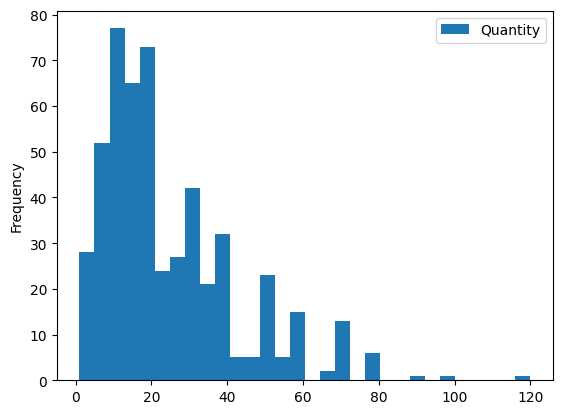

In [ ]:
{
    DataFrame[["Quantity"]]
    .plot(
        kind="hist",
        bins=30)
};

###Krydstabulering

Bemærk: MONTH or YEAR funktionerne findes ikke SQLite. I stedet for må man bruge SQLite funktionen i SQLite

In [ ]:
query = """
SELECT Customers.CustomerID, CustomerName, Country, OrderID, OrderDate, strftime('%m', OrderDate) AS Month, strftime('%Y', OrderDate) AS Year
FROM Customers
JOIN Orders ON Customers.CustomerID=Orders.CustomerID
ORDER BY OrderDate
"""
DataFrame = pd.read_sql(query, SQLiteConnetion)
DataFrame

,CustomerID,CustomerName,Country,OrderID,OrderDate,Month,Year
0,90,Wilman Kala,Finland,10248,1996-07-04 00:00:00,07,1996
1,81,Tradição Hipermercados,Brazil,10249,1996-07-05 00:00:00,07,1996
2,34,Hanari Carnes,Brazil,10250,1996-07-08 00:00:00,07,1996
3,84,Victuailles en stock,France,10251,1996-07-08 00:00:00,07,1996
4,76,Suprêmes délices,Belgium,10252,1996-07-09 00:00:00,07,1996
...,...,...,...,...,...,...,...
191,51,Mère Paillarde,Canada,10439,1997-02-07 00:00:00,02,1997
192,71,Save-a-lot Markets,USA,10440,1997-02-10 00:00:00,02,1997
193,55,Old World Delicatessen,USA,10441,1997-02-10 00:00:00,02,1997
194,20,Ernst Handel,Austria,10442,1997-02-11 00:00:00,02,1997


In [ ]:
pd.crosstab(DataFrame['Country'],DataFrame['Year'])

Year,1996,1997
Country,,
Argentina,0,1
Austria,8,5
Belgium,2,0
Brazil,14,5
Canada,4,5
Denmark,3,1
Finland,5,3
France,14,4
Germany,22,3


###SQL - GROUP BY & ORDER BY - Bar chart

In [ ]:
query = """
SELECT Categories.CategoryID, CategoryName ,Sum(Price*Quantity) AS Revenue
FROM OrderDetails
JOIN Products ON Products.ProductID=OrderDetails.ProductID
JOIN Categories ON Categories.CategoryID=Products.CategoryID
GROUP BY Products.CategoryID
;"""
DataFrame = pd.read_sql(query,SQLiteConnetion)
DataFrame

,CategoryID,CategoryName,Revenue
0,1,Beverages,99699
1,2,Condiments,35024
2,3,Confections,54729
3,4,Dairy Products,70530
4,5,Grains/Cereals,22370
5,6,Meat/Poultry,51636
6,7,Produce,23439
7,8,Seafood,29639


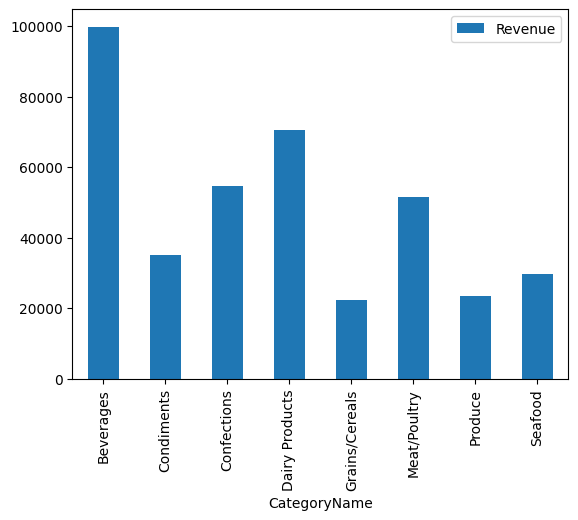

In [ ]:
{
    DataFrame
    .sort_values('CategoryName', ascending=True)
    .plot(kind='bar', x='CategoryName', y='Revenue')
};

###SQL - JOIN - Omsætning pr. leverandør - Bar chart

In [ ]:
query = """
SELECT Suppliers.SupplierID, SupplierName ,Sum(Price*Quantity) AS Revenue
FROM OrderDetails
JOIN Products ON Products.ProductID=OrderDetails.ProductID
JOIN Suppliers ON Suppliers.SupplierID=Products.SupplierID
GROUP BY Products.SupplierID
ORDER BY Products.SupplierID
;"""
DataFrame = pd.read_sql(query,SQLiteConnetion)
DataFrame


,SupplierID,SupplierName,Revenue
0,1,Exotic Liquid,10141
1,2,New Orleans Cajun Delights,10268
2,3,Grandma Kelly's Homestead,7250
3,4,Tokyo Traders,6435
4,5,Cooperativa de Quesos 'Las Cabras',4848
5,6,Mayumi's,4448
6,7,"Pavlova, Ltd.",36989
7,8,"Specialty Biscuits, Ltd.",14272
8,9,PB Knäckebröd AB,1863
9,10,Refrescos Americanas LTDA,790


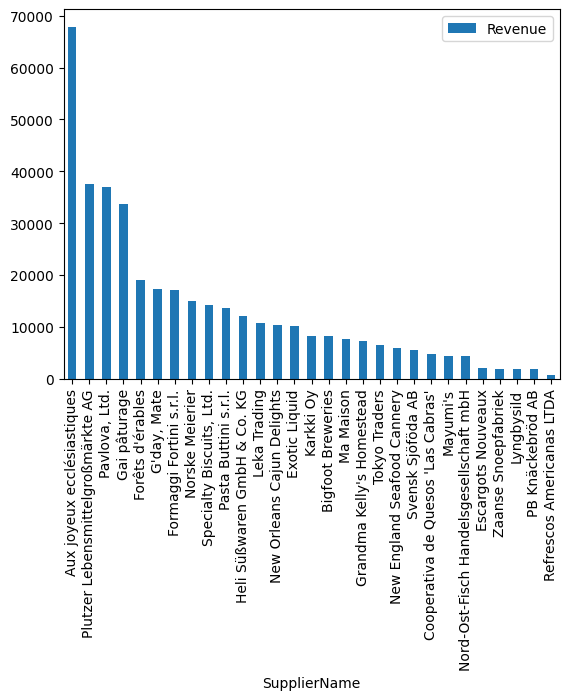

In [ ]:

{
    DataFrame
    .sort_values('Revenue', ascending=False)
    .plot(kind='bar', x='SupplierName', y='Revenue')
};